# Libraries

In [45]:
import os  # Для работы с файловой системой
import sep  # Для извлечения и анализа источников на астрономических изображениях
import pandas as pd  # Для работы с таблицами данных
import matplotlib.pyplot as plt  # Для построения графиков и визуализации данных
from astropy.io import fits  # Для чтения и записи FITS файлов, стандартного формата астрономических данных
from astropy.wcs import WCS  # Для работы с мировой координатной системой (WCS) в астрономических изображениях
from matplotlib.patches import Circle  # Для рисования кругов на графиках
import numpy as np  # Для работы с массивами чисел и выполнения численных операций
from scipy.stats import norm  # Для работы со статистическим нормальным распределением
from scipy.optimize import curve_fit
from astropy.stats import sigma_clipped_stats  # Для расчета статистик с исключением выбросов (сигма-клиппинг)
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Для создания делимых областей на графиках
from concurrent.futures import ThreadPoolExecutor  # Для параллельного выполнения задач
from astropy.visualization import ZScaleInterval, MinMaxInterval  # Для масштабирования изображений
import time
from tqdm import tqdm
from astroquery.gaia import Gaia
from scipy.ndimage import gaussian_filter
import cv2
from concurrent.futures import ThreadPoolExecutor
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord 
from itertools import cycle

# Functions

In [1]:
def subtract_background(fits_file, output_directory, bw, bh, fw, fh, data=None, header=None):
    """
    Выполняет вычитание фона из данных FITS файла и сохраняет результат.

    Параметры:
    fits_file : str
        Путь к входному FITS файлу.
    output_directory : str
        Путь к выходному каталогу для сохранения обработанных файлов.
    bw : int
        Ширина блока для оценки фона.
    bh : int
        Высота блока для оценки фона.
    fw : int
        Ширина фильтра для сглаживания фона.
    fh : int
        Высота фильтра для сглаживания фона.

    Возвращаемые значения:
    data_sub : ndarray
        Данные с вычитанным фоном.
    bkg : sep.Background
        Объект фона.
    header : astropy.io.fits.Header
        Заголовок FITС файла.
    """
    print(f"Processing file: {fits_file}")
    if data is None:
        with fits.open(fits_file) as hdul:
            data = hdul[0].data
            header = hdul[0].header
        
    file_name = fits_file.split("/")[-1].replace(".fits", "").replace(".fit", "")
    if data is None or data.size == 0:
        print(f"Warning: No data in FITС file {fits_file}")
        return None, None, None

    data = data.astype(np.float32)
    
    bkg = sep.Background(data, bw=bw, bh=bh, fw=fw, fh=fh)
    data_sub = data - bkg
    
    mean_data, median_data, std_data = sigma_clipped_stats(data, sigma=3.0)
    mean_data_sub, median_data_sub, std_data_sub = sigma_clipped_stats(data_sub, sigma=3.0)
    mean_bkg, median_bkg, std_bkg = sigma_clipped_stats(bkg.back(), sigma=3.0)
    
    # Создание фигуры и осей
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))
    
    # Initial frame
    axs[0].hist(data.ravel(), bins=256, histtype='step', color='black')
    axs[0].axvline(x=mean_data, color='r', linestyle='--', label=f'Mean: {mean_data:.1f}')
    axs[0].axvline(x=mean_data + std_data, color='g', linestyle='--', label=f'STD: {std_data:.1f}')
    axs[0].axvline(x=mean_data - std_data, color='g', linestyle='--')
    axs[0].set_xlim([mean_data - 5*std_data, mean_data + 5*std_data])
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].set_title('Initial frame')
    axs[0].set_xlabel('Pixel Value')
    axs[0].set_ylabel('Frequency')
    axs[0].legend(loc="upper right")
    
    # Background
    axs[1].hist(bkg.back().ravel(), bins=256, histtype='step', color='black')
    axs[1].axvline(x=mean_bkg, color='r', linestyle='--', label=f'Mean: {mean_bkg:.1f}')
    axs[1].axvline(x=mean_bkg + std_bkg, color='g', linestyle='--', label=f'STD: {std_bkg:.1f}')
    axs[1].axvline(x=mean_bkg - std_bkg, color='g', linestyle='--')
    axs[1].set_xlim([mean_bkg - 5*std_data, mean_bkg + 5*std_data])
    axs[1].tick_params(axis='x', rotation=45)
    axs[1].set_title('Background')
    axs[1].set_xlabel('Pixel Value')
    axs[1].set_ylabel('Frequency')
    axs[1].legend(loc="upper right")
    
    # Distribution with X-Limits after subtraction
    axs[2].hist(data_sub.ravel(), bins=256, histtype='step', color='black')
    axs[2].axvline(x=mean_data_sub, color='r', linestyle='--', label=f'Mean: {mean_data_sub:.1f}')
    axs[2].axvline(x=mean_data_sub + std_data_sub, color='g', linestyle='--', label=f'STD: {std_data_sub:.1f}')
    axs[2].axvline(x=mean_data_sub - std_data_sub, color='g', linestyle='--')
    axs[2].set_xlim([mean_data_sub - 5*std_data_sub, mean_data_sub + 5*std_data_sub])
    axs[2].set_title('Distribution after subtraction')
    axs[2].set_xlabel('Pixel Value')
    axs[2].set_ylabel('Frequency')
    axs[2].legend(loc="upper right")
    axs[2].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f'{file_name}_pix_distrib.png'), dpi=300)
    plt.show()

    # Построение изображений с правильными размерами colorbar
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Первое изображение
    img0 = axs[0].imshow(data, cmap='gray', origin='lower')
    axs[0].set_title('Initial data')
    divider0 = make_axes_locatable(axs[0])
    cax0 = divider0.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img0, cax=cax0)
    
    # Второе изображение
    img1 = axs[1].imshow(data_sub, cmap='gray', origin='lower')
    axs[1].set_title('Data after Background Subtraction')
    divider1 = make_axes_locatable(axs[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax1)
    
    # Третье изображение
    img2 = axs[2].imshow(bkg.back(), cmap='gray', origin='lower')
    axs[2].set_title('Background')
    divider2 = make_axes_locatable(axs[2])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img2, cax=cax2)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f'{file_name}_sub_comparison.png'), dpi=300)
    plt.show()

    return data_sub, bkg, header

def evaluate_background_params(data, bw, bh, fw, fh):
    """
    Оценивает параметры фона для данных.
    """
    bkg = sep.Background(data, bw=bw, bh=bh, fw=fw, fh=fh)
    return bkg.globalrms, (bw, bh, fw, fh)


def find_best_background_params(fits_file, output_directory, data=None):
    """
    Находит наилучшие параметры для вычитания фона и строит график зависимости ошибки от параметров.
    
    Параметры:
    fits_file : str
        Путь к FITS файлу.
    output_directory : str
        Путь к каталогу для сохранения выходных изображений.
    data : ndarray, optional
        Данные изображения, если уже загружены.
        
    Возвращаемые значения:
    best_params : tuple
        Наилучшие параметры (bw, bh, fw, fh).
    all_results : list
        Список всех результатов в виде (rms, params).
    """
    if data is None:
        with fits.open(fits_file) as hdul:
            data = hdul[0].data.astype(np.float32)
        
    file_name = fits_file.split("/")[-1].replace(".fits", "").replace(".fit", "")
    
    bw_values = [32, 64, 128]
    fw_values = [3, 5, 7]

    best_rms = np.inf
    best_params = None
    all_results = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for bw in bw_values:
            for fw in fw_values:
                futures.append(executor.submit(evaluate_background_params, data, bw, bw, fw, fw))

        for future in futures:
            rms, params = future.result()
            all_results.append((rms, params))
            if rms < best_rms:
                best_rms = rms
                best_params = params

    # Замена параметров на более крупные, если они слишком малы
    if best_params == (32, 32, 3, 3):
        best_params = (64, 64, 5, 5)
        best_rms = next(rms for rms, params in all_results if params == (64, 64, 5, 5))

    # Построение графика зависимости ошибки от параметров
    rms_values = [result[0] for result in all_results]
    param_values = [f'bw={result[1][0]}, fw={result[1][2]}' for result in all_results]

    best_index = rms_values.index(best_rms)

    plt.figure(figsize=(8, 4))
    plt.plot(param_values, rms_values, 'o-', label='All parameters')
    plt.plot(param_values[best_index], rms_values[best_index], 'r*', label='Best parameter', markersize=15)
    plt.xticks(rotation=45)
    plt.xlabel('Parameters (bw, fw)')
    plt.ylabel('Global RMS Error')
    plt.title('Error vs Parameters')
    plt.legend()
    plt.tight_layout()
    plt.grid(alpha=0.25, lw=1, ls="-")
    plt.savefig(os.path.join(output_directory, f'{file_name}_error_vs_params.png'))
    plt.show()

    return best_params, all_results

def save_global_differences(output_directory):
    """
    Сохраняет глобальные разницы по координатам RA и Dec в отдельные текстовые файлы.
    """
    global ra_diff_global, dec_diff_global

    np.savetxt(os.path.join(output_directory, "global_ra_diff.txt"), ra_diff_global, fmt='%f')
    np.savetxt(os.path.join(output_directory, "global_dec_diff.txt"), dec_diff_global, fmt='%f')

def process_directory(directory, output_directory, circle_radius=10, scale='zscale'):
    """
    Обрабатывает все FITS файлы в указанном каталоге, выполняя вычитание фона и извлечение объектов.
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    fits_files = [f for f in os.listdir(directory) if f.endswith('.fit') or f.endswith('.fits')]
    total_files = len(fits_files)

    for i, filename in enumerate(tqdm(fits_files, desc="Processing files", total=total_files)):
        start_time = time.time()
        
        fits_file = os.path.join(directory, filename)
        with fits.open(fits_file) as hdul:
            data = hdul[0].data.astype(np.float32)
            header = hdul[0].header
        
        data_v = data  # remove_objects_and_correct_vignetting(fits_file, reduction_factor=50)
        
        best_params, all_results = find_best_background_params(fits_file, output_directory, data=data_v)
        if best_params is not None:
            bw, bh, fw, fh = best_params
            data_sub, bkg, header = subtract_background(fits_file, output_directory, bw, bh, fw, fh, data=data_v, header=header)
            if data_sub is not None:

                objects_df = extract_and_export_objects(data_sub, bkg, header, output_directory, fits_file)
                ra_min, ra_max, dec_min, dec_max = find_ra_dec_bounds(header)

                print("RA max = ",  round(ra_max, 3))
                print("RA min = ",  round(ra_min, 3))
                print("DEC max = ", round(dec_max,3))
                print("DEC min = ", round(dec_min,3))

        end_time = time.time()
        print(f"Processed {filename} ({i+1}/{total_files}) in {end_time - start_time:.2f} seconds.")
        print("-------------------------------------------")
                        

def plot_objects(image_data, objects, output_image, scale='zscale'):
    """
    Визуализирует объекты на изображении и сохраняет результат в файл с возможностью выбора шкалы.

    Параметры:
    image_data : ndarray
        Данные изображения.
    objects : list
        Список объектов, извлеченных из изображения.
    output_image : str
        Путь к файлу для сохранения изображения.
    scale : str
        Шкала для отображения изображения (допустимые значения: 'linear', 'zscale', 'minmax').
    """
    from astropy.visualization import ZScaleInterval, MinMaxInterval

    if scale == 'zscale':
        interval = ZScaleInterval()
    elif scale == 'minmax':
        interval = MinMaxInterval()
    else:
        interval = None

    if interval:
        vmin, vmax = interval.get_limits(image_data)
    else:
        vmin, vmax = 0, np.percentile(image_data, 99)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)

    for obj in objects:
        # Проверка наличия ключей 'a' и 'b'
        if 'a' in obj and 'b' in obj:
            radius = 3 * np.sqrt(obj['a'] * obj['b'])  # Расчет радиуса на основе полуосей объекта
        else:
            radius = 10  # Если нет параметров 'a' и 'b', использовать фиксированный радиус

        e = Circle((obj['x'], obj['y']), radius=radius, edgecolor='green', facecolor='none', lw=.8)
        ax.add_patch(e)

    ax.axis('off')  # Отключает оси
    plt.savefig(output_image, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

def extract_and_export_objects(data_sub, bkg, header, output_directory, fits_file):
    """
    Извлекает объекты из данных с вычитанным фоном и сохраняет их параметры в CSV файл.
    Также создаёт отдельный CSV файл с 10 самыми яркими объектами.

    Параметры:
    data_sub : ndarray
        Данные с вычитанным фоном.
    bkg : sep.Background
        Объект фона.
    header : astropy.io.fits.Header
        Заголовок FITС файла.
    output_directory : str
        Путь к выходному каталогу для сохранения обработанных файлов.
    fits_file : str
        Путь к исходному FITС файлу для сохранения имени.

    Возвращаемые значения:
    df : pandas.DataFrame
        Таблица с параметрами объектов.
    df_top10 : pandas.DataFrame
        Таблица с параметрами 10 самых ярких объектов.
    """
    if data_sub is None or bkg is None or header is None:
        print("Invalid input data.")
        return None, None

    thresh = 5.0
    minarea = 20
    err = bkg.globalrms

    deblend_nthresh = 32
    deblend_cont = 0.05
    clean = True
    clean_param = 1.0
    
    sep.set_extract_pixstack(1e7) 
    
    objects = sep.extract(data_sub, thresh, err=err, minarea=minarea, deblend_nthresh=deblend_nthresh,
                          deblend_cont=deblend_cont, clean=clean, clean_param=clean_param)

    if len(objects) == 0:
        print(f"No objects found in {fits_file}")
        return None, None
    else:
        print(f"{len(objects)} objects found in {fits_file}")

    wcs = WCS(header)
    objects_coords = wcs.all_pix2world(objects['x'], objects['y'], 1)

    flux, flux_err, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=err, gain=1.0)
    mag = -2.5 * np.log10(flux)
    mag_err = 2.5 / np.log(10) * (flux_err / flux)

    data = {
        'id': range(len(objects)),
        'x': objects['x'],
        'y': objects['y'],
        'ra': objects_coords[0],
        'dec': objects_coords[1],
        'flux': flux,
        'flux_err': flux_err,
        'mag': mag,
        'mag_err': mag_err,
        'flag': flag
    }

    # Добавление параметров 'a' и 'b' в таблицу объектов
    if 'a' in objects.dtype.names and 'b' in objects.dtype.names:
        data['a'] = objects['a']
        data['b'] = objects['b']

    df = pd.DataFrame(data)

    # Сортировка объектов по яркости (меньше значение магнитуды — ярче объект)
    df_sorted = df.sort_values(by='mag')
    top_amount = int(len(df_sorted)*0.01)
    # Выбор 10 самых ярких объектов
    df_top10 = df_sorted.head(top_amount)

    base_name = os.path.splitext(os.path.basename(fits_file))[0]

    # Сохранение основной таблицы
    output_csv_file = os.path.join(output_directory, f"{base_name}_objects.csv")
    df.to_csv(output_csv_file, index=False)

    # Сохранение таблицы с 10 самыми яркими объектами
    output_top_csv_file = os.path.join(output_directory, f"{base_name}_top{top_amount}_objects.csv")
    df_top10.to_csv(output_top_csv_file, index=False)

    return df


def plot_matching_errors(matches_df, header, output_directory=".", file_base_name="unknown"):
    """
    Отображает ошибки сопоставления координат (разница между RA и Dec) в виде графиков.

    Параметры:
    matches_df : pandas.DataFrame
        DataFrame с колонками 'ra_diff', 'dec_diff', 'x', 'y'.
    header : astropy.io.fits.Header
        Заголовок FITS файла для определения соответствия осей координат.
    """

    # Определение типа координат по осям
    x_label = "RA Difference" if "RA" in header['CTYPE1'] else "Dec Difference"
    y_label = "RA Difference" if "RA" in header['CTYPE2'] else "Dec Difference"

    # Построение графиков разницы координат по осям
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].scatter( matches_df['ra_diff']*3600, matches_df['x'], s=1)
    axs[0].set_ylabel("X coordinate")
    axs[0].set_xlabel(x_label +" (arcsec)")
    axs[0].set_title("RA Difference vs X coordinate")
    axs[0].grid(True)

    axs[1].scatter(matches_df['dec_diff']*3600, matches_df['y'], s=1)
    axs[1].set_ylabel("Y coordinate")
    axs[1].set_xlabel(y_label +" (arcsec)")
    axs[1].set_title("Dec Difference vs Y coordinate")
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, file_base_name+"_coords_err.png"), bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

def find_ra_dec_bounds(header):
    # Создаем объект WCS
    wcs = WCS(header)
    
    # Размеры изображения
    naxis1 = header['NAXIS1']
    naxis2 = header['NAXIS2']
    
    # Координаты угловых пикселей
    corners = np.array([[1, 1], [naxis1, 1], [1, naxis2], [naxis1, naxis2]])
    
    # Преобразуем пиксельные координаты в небесные (RA, DEC)
    world_coords = wcs.all_pix2world(corners, 1)
    
    # Извлекаем RA и DEC
    ra_vals = world_coords[:, 0]
    dec_vals = world_coords[:, 1]
    
    # Определяем минимальные и максимальные значения RA и DEC
    ra_min, ra_max = np.min(ra_vals), np.max(ra_vals)
    dec_min, dec_max = np.min(dec_vals), np.max(dec_vals)
    
    return ra_min, ra_max, dec_min, dec_max

In [41]:
plt.rcParams.update({
    'figure.figsize': (8, 6),  # Размеры графиков
    'figure.dpi': 100,  # Разрешение графиков
    'savefig.dpi': 300,  # Разрешение сохраненных изображений
    'font.size': 12,  # Размер шрифта
    'font.family': 'serif',  # Семейство шрифтов
    'axes.labelsize': 14,  # Размер шрифта для подписей осей
    'axes.titlesize': 14,  # Размер шрифта для заголовков
    'xtick.labelsize': 12,  # Размер шрифта для подписей меток на оси X
    'ytick.labelsize': 12,  # Размер шрифта для подписей меток на оси Y
    'legend.fontsize': 10,  # Размер шрифта для легенды
    'lines.linewidth': 1,  # Толщина линий
    'lines.markersize': 6,  # Размер маркеров
    'axes.grid': False,  # Сетка на графиках
    'grid.alpha': 0.25,  # Прозрачность сетки
    'grid.linestyle': '--',  # Стиль линии сетки
    'grid.color': 'gray',  # Цвет сетки
    'axes.axisbelow': True,  # Сетка ниже данных
    'image.cmap': 'viridis',  # Цветовая карта для изображений
    'errorbar.capsize': 3,  # Размер "колпачков" на графиках ошибок
    "legend.loc": 'best', 
})

# Implementation

In [4]:
# Укажи путь к директории с FITS файлами и директории для сохранения результатов
fits_directory = os.getcwd() + '/data/'
output_directory = os.getcwd() + '/output/'

Processing files:   0%|                                  | 0/20 [00:00<?, ?it/s]

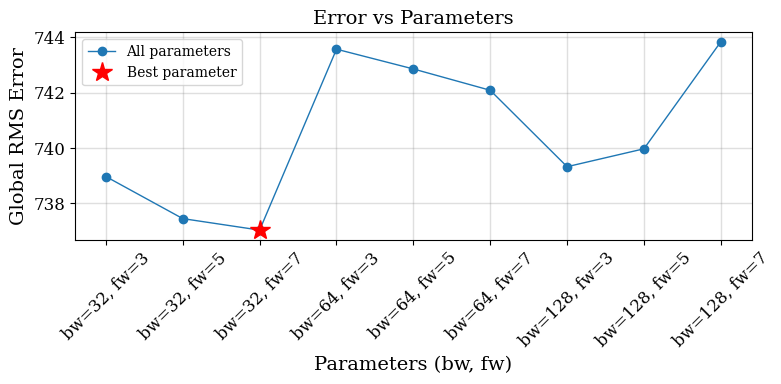

Processing file: /home/izm-ildana/astro/variable_search/data/alf-Cyg_11-12.11.1985_40m_70S-4.fit


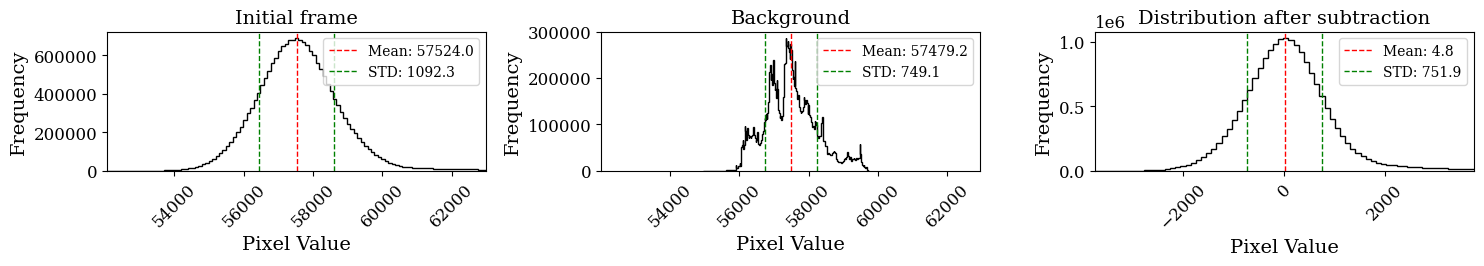

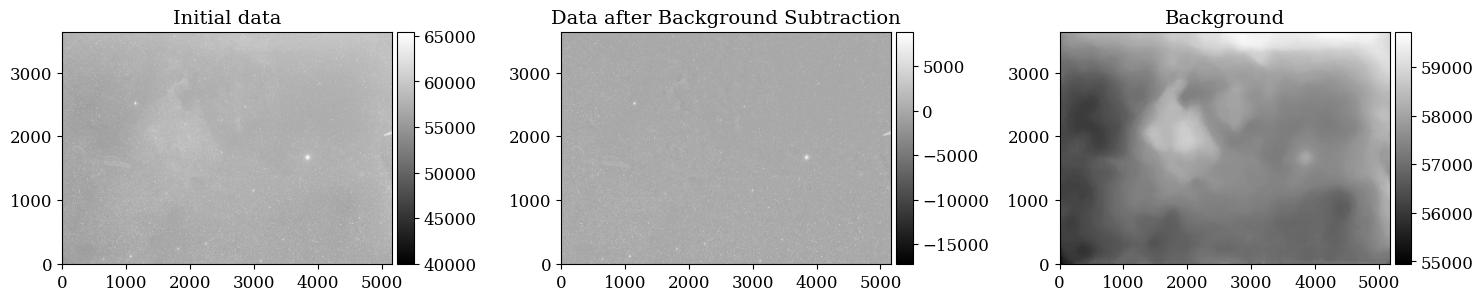

Processing files:   5%|█▎                        | 1/20 [00:18<05:48, 18.36s/it]

3042 objects found in /home/izm-ildana/astro/variable_search/data/alf-Cyg_11-12.11.1985_40m_70S-4.fit
RA max =  319.137
RA min =  307.192
DEC max =  47.774
DEC min =  42.053
Processed alf-Cyg_11-12.11.1985_40m_70S-4.fit (1/20) in 18.36 seconds.
-------------------------------------------


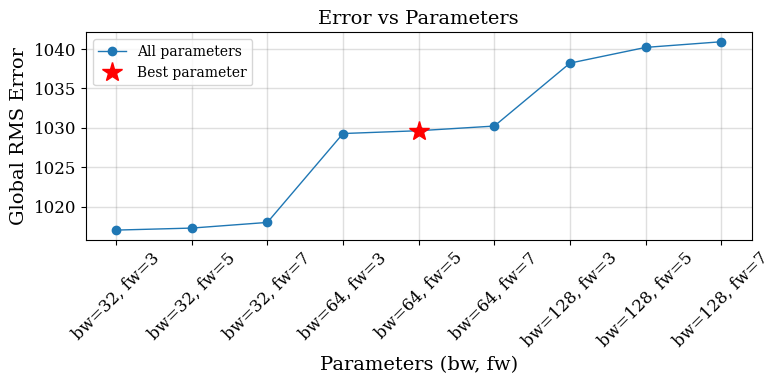

Processing file: /home/izm-ildana/astro/variable_search/data/sky_21-22.09.1987_10.5m_5S-2-9.fit


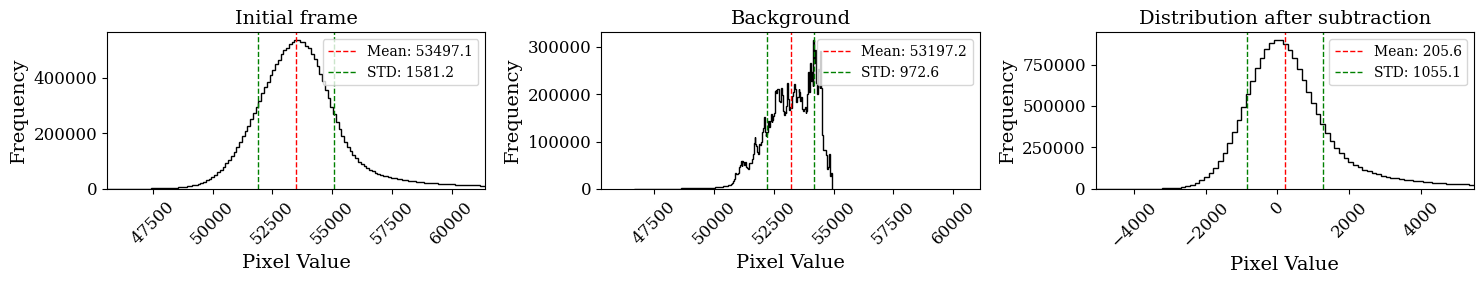

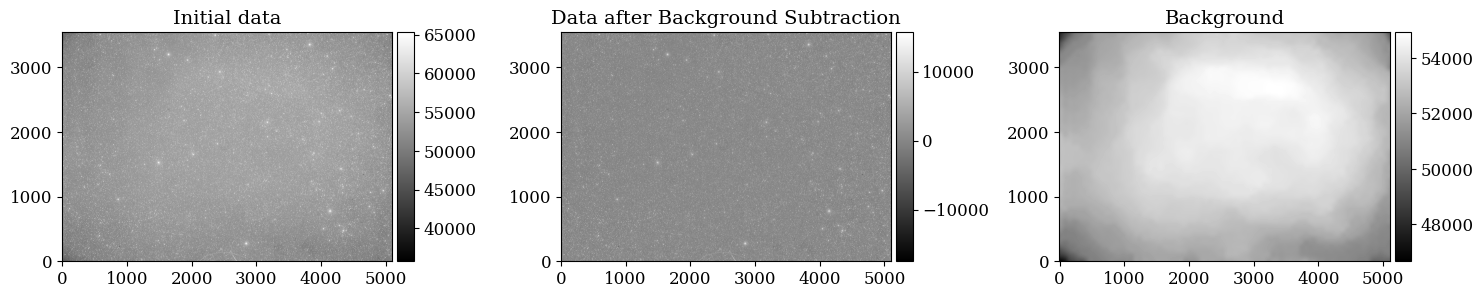

Processing files:  10%|██▌                       | 2/20 [00:35<05:18, 17.68s/it]

7483 objects found in /home/izm-ildana/astro/variable_search/data/sky_21-22.09.1987_10.5m_5S-2-9.fit
RA max =  353.467
RA min =  339.457
DEC max =  55.519
DEC min =  49.868
Processed sky_21-22.09.1987_10.5m_5S-2-9.fit (2/20) in 17.20 seconds.
-------------------------------------------


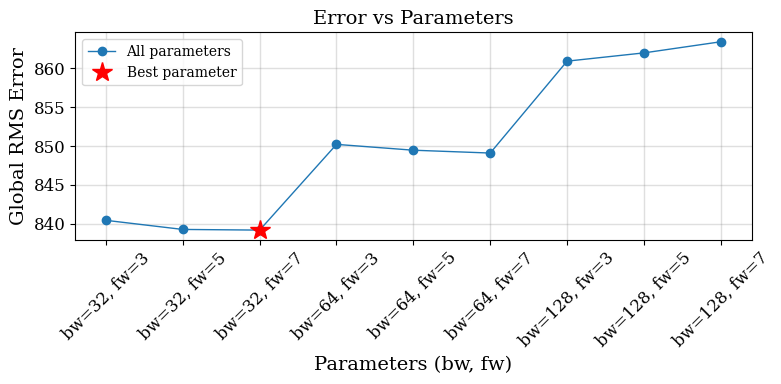

Processing file: /home/izm-ildana/astro/variable_search/data/sky_21-22.09.1987_10m_5S-2-10.fit


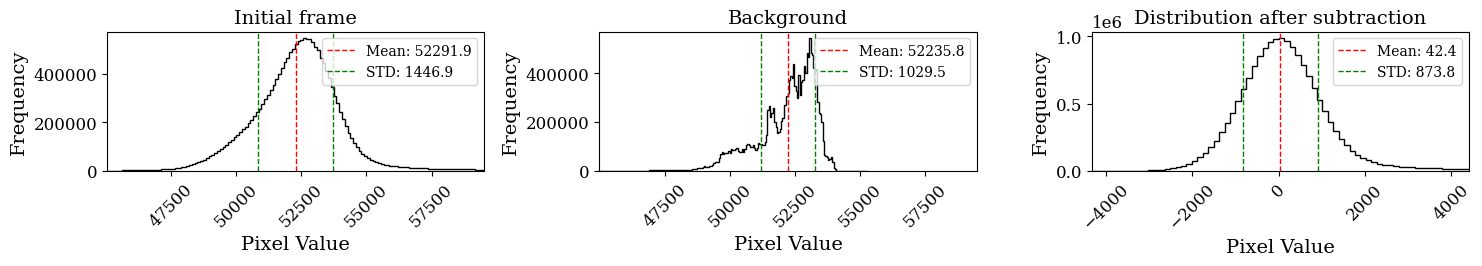

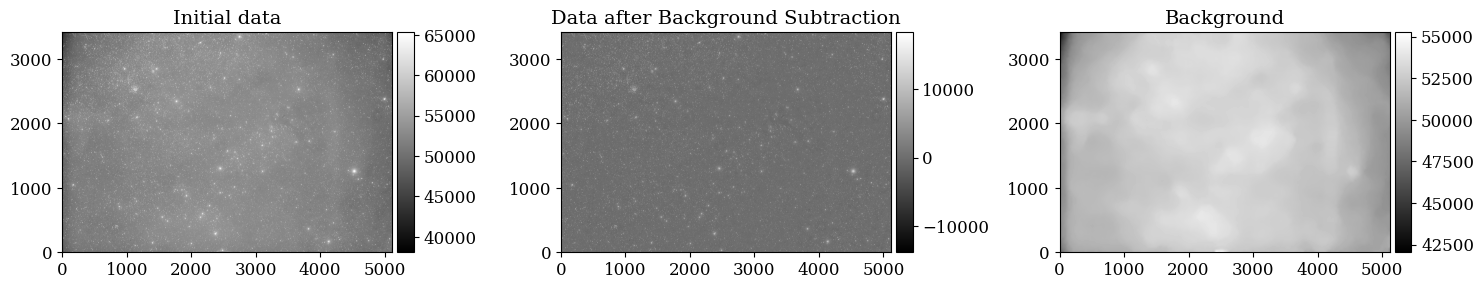

Processing files:  15%|███▉                      | 3/20 [00:51<04:47, 16.93s/it]

6069 objects found in /home/izm-ildana/astro/variable_search/data/sky_21-22.09.1987_10m_5S-2-10.fit
RA max =  356.173
RA min =  336.997
DEC max =  65.425
DEC min =  60.015
Processed sky_21-22.09.1987_10m_5S-2-10.fit (3/20) in 16.04 seconds.
-------------------------------------------


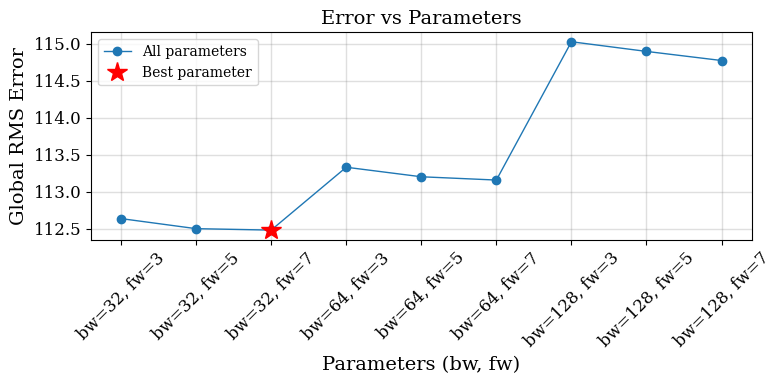

Processing file: /home/izm-ildana/astro/variable_search/data/Nebula_03-04.11.1991_20m_14K-0.fit


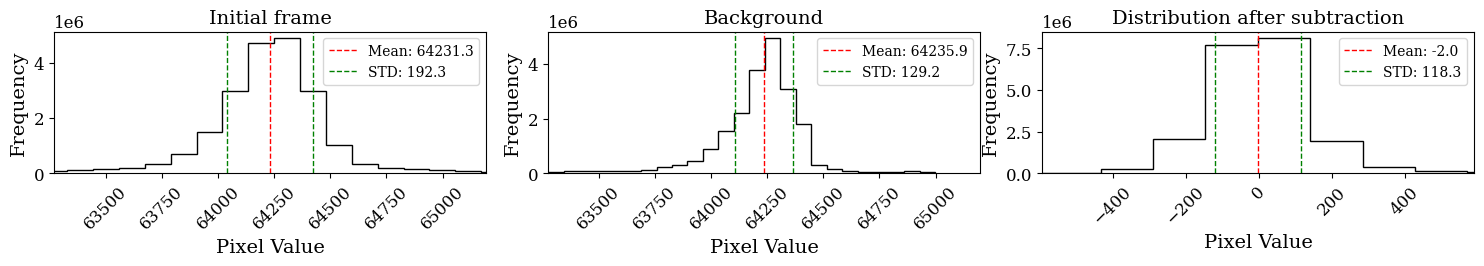

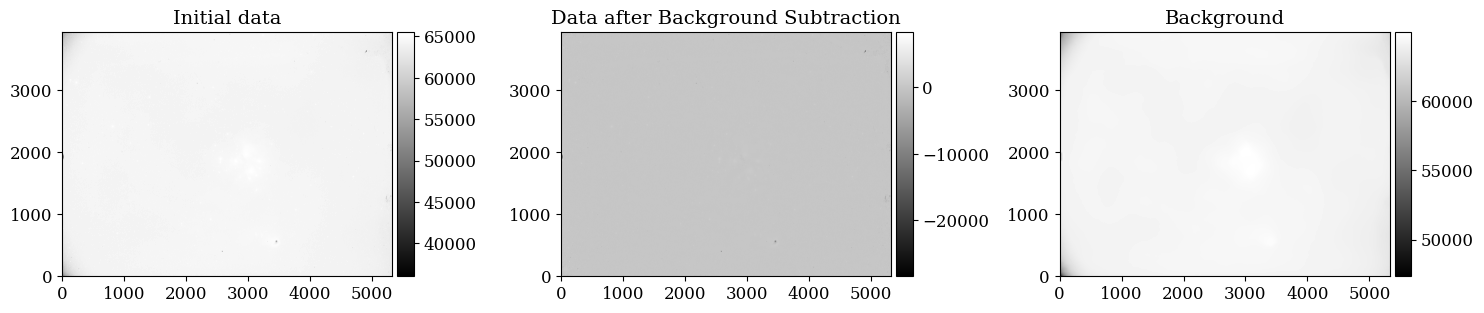

Processing files:  20%|█████▏                    | 4/20 [01:10<04:44, 17.78s/it]

2739 objects found in /home/izm-ildana/astro/variable_search/data/Nebula_03-04.11.1991_20m_14K-0.fit
RA max =  61.781
RA min =  52.426
DEC max =  26.947
DEC min =  20.769
Processed Nebula_03-04.11.1991_20m_14K-0.fit (4/20) in 19.09 seconds.
-------------------------------------------


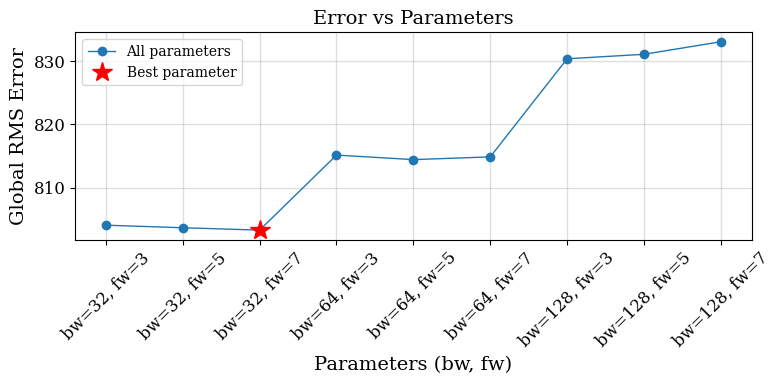

Processing file: /home/izm-ildana/astro/variable_search/data/M44_24-25.02.1987_8m_14S-3-1.fit


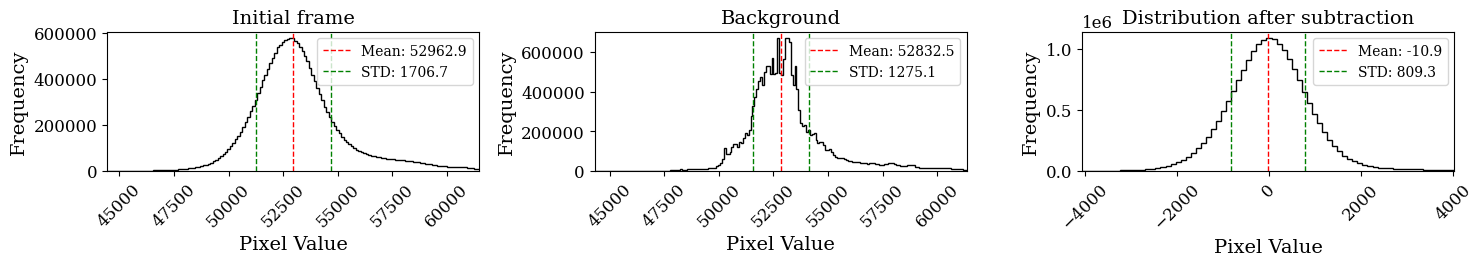

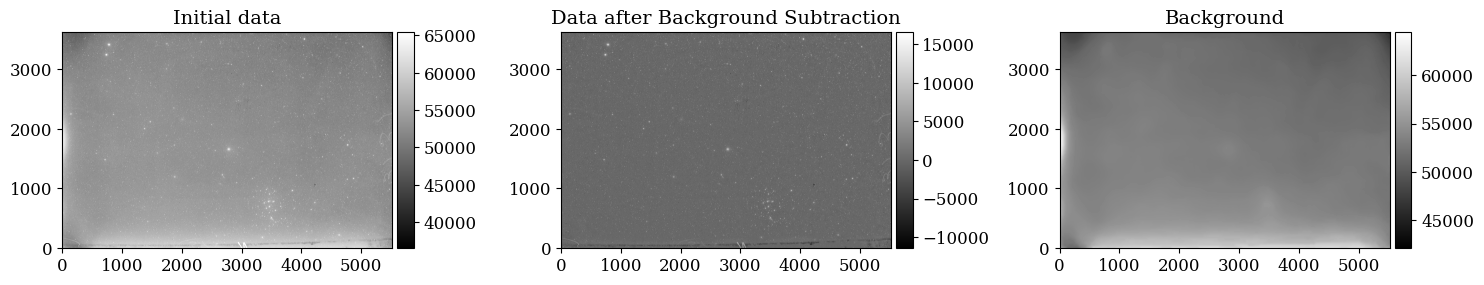

/tmp/ipykernel_65156/1028180206.py:408: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)
Processing files:  25%|██████▌                   | 5/20 [01:27<04:21, 17.45s/it]

2106 objects found in /home/izm-ildana/astro/variable_search/data/M44_24-25.02.1987_8m_14S-3-1.fit
RA max =  135.886
RA min =  126.636
DEC max =  20.79
DEC min =  14.916
Processed M44_24-25.02.1987_8m_14S-3-1.fit (5/20) in 16.85 seconds.
-------------------------------------------


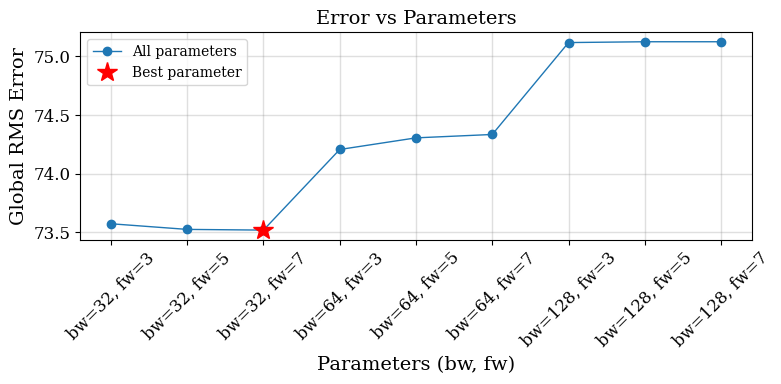

Processing file: /home/izm-ildana/astro/variable_search/data/Pleiades_28-29.11.1981__14K-250.fit


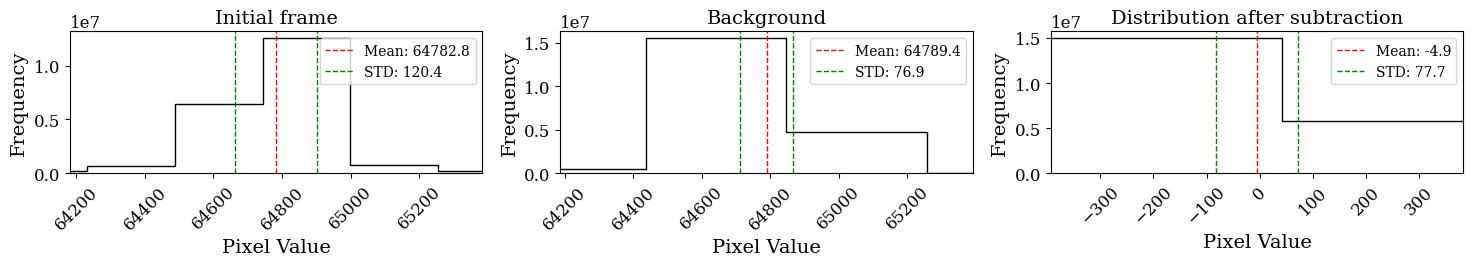

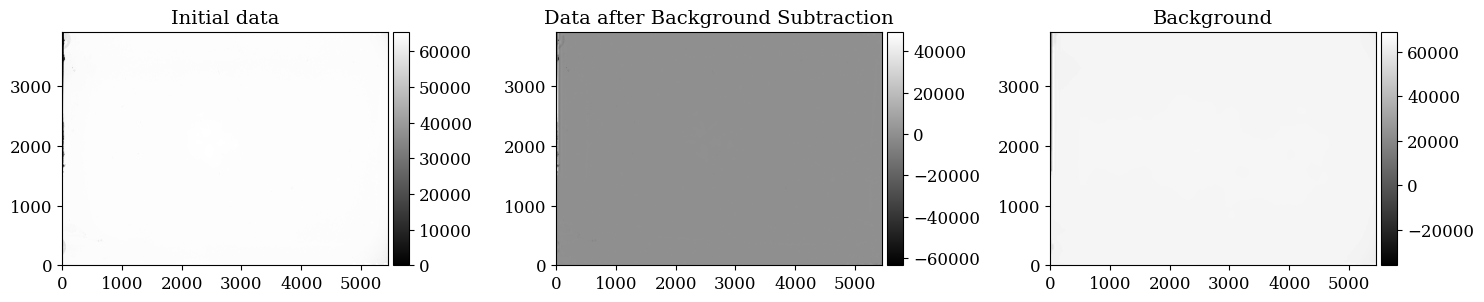

/tmp/ipykernel_65156/1028180206.py:408: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)
Processing files:  30%|███████▊                  | 6/20 [01:44<04:02, 17.31s/it]

1240 objects found in /home/izm-ildana/astro/variable_search/data/Pleiades_28-29.11.1981__14K-250.fit
RA max =  61.678
RA min =  52.123
DEC max =  27.08
DEC min =  20.724
Processed Pleiades_28-29.11.1981__14K-250.fit (6/20) in 17.04 seconds.
-------------------------------------------


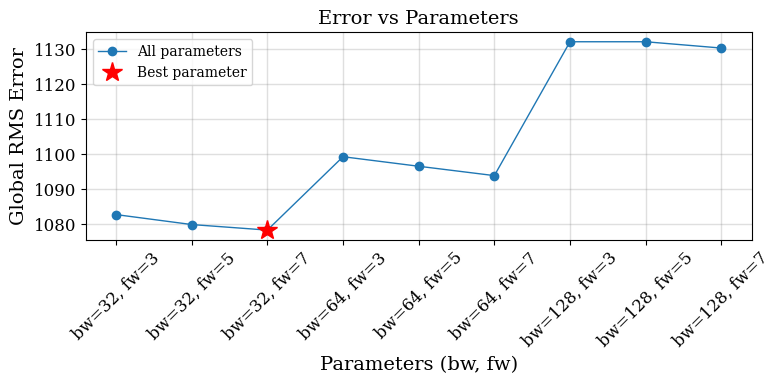

Processing file: /home/izm-ildana/astro/variable_search/data/IC1396_07-08.04.1980_60m_14K-208.fit


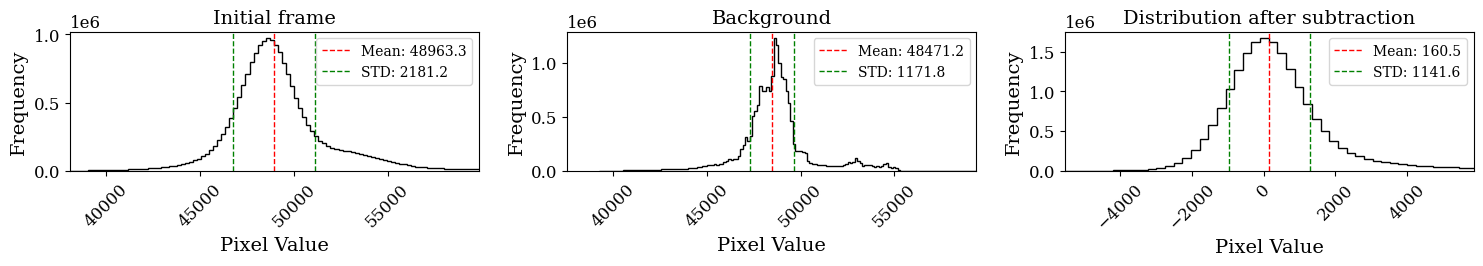

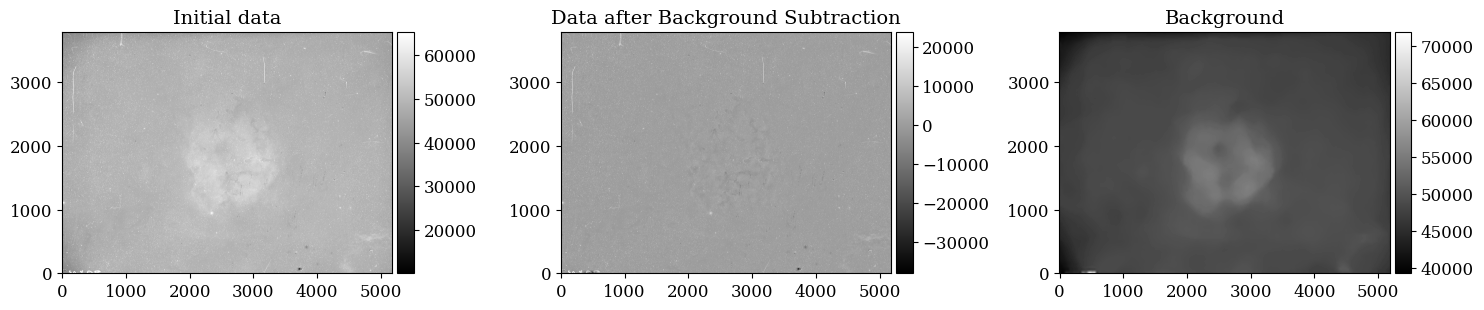

Processing files:  35%|█████████                 | 7/20 [02:02<03:48, 17.60s/it]

6571 objects found in /home/izm-ildana/astro/variable_search/data/IC1396_07-08.04.1980_60m_14K-208.fit
RA max =  333.272
RA min =  317.063
DEC max =  60.13
DEC min =  54.044
Processed IC1396_07-08.04.1980_60m_14K-208.fit (7/20) in 18.19 seconds.
-------------------------------------------


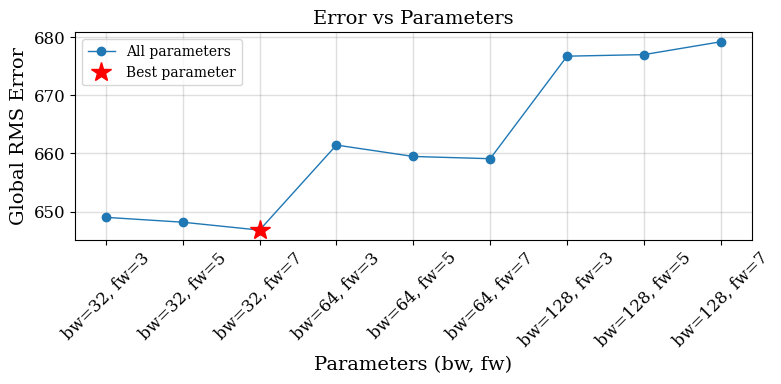

Processing file: /home/izm-ildana/astro/variable_search/data/Star_15-16.06.1988_10m_38S-3-5.fit


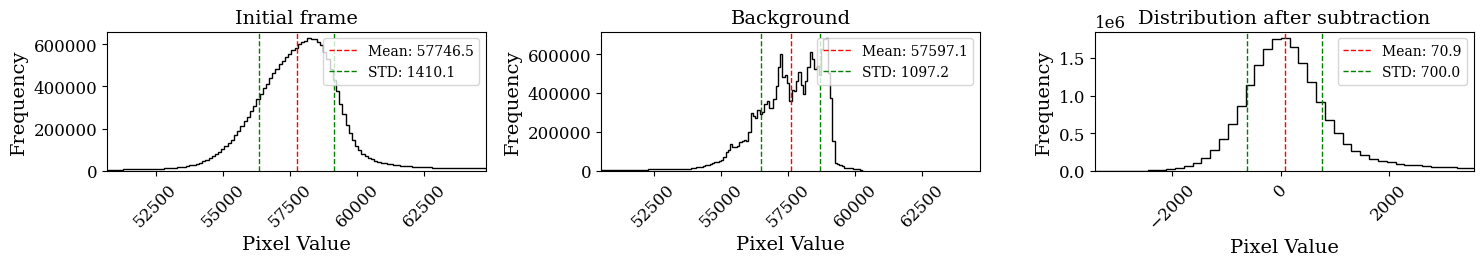

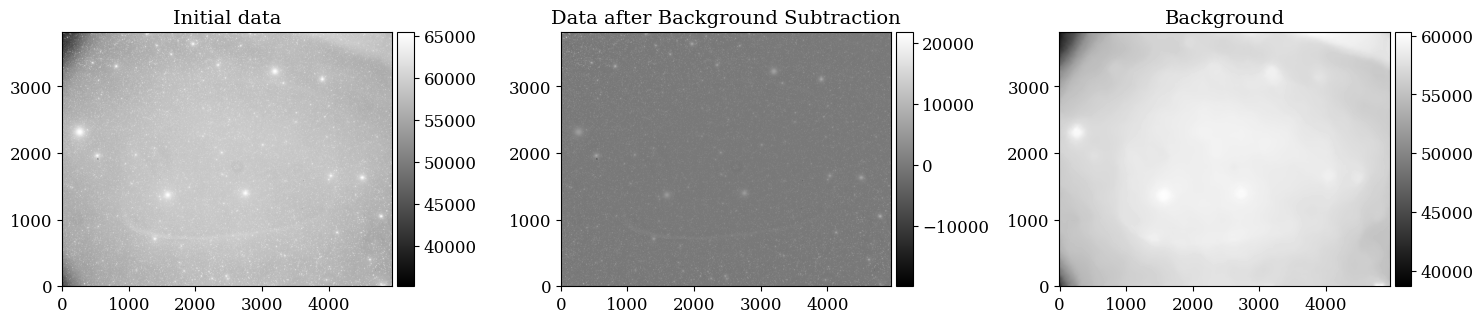

Processing files:  40%|██████████▍               | 8/20 [02:20<03:30, 17.52s/it]

7109 objects found in /home/izm-ildana/astro/variable_search/data/Star_15-16.06.1988_10m_38S-3-5.fit
RA max =  293.808
RA min =  280.235
DEC max =  55.484
DEC min =  49.338
Processed Star_15-16.06.1988_10m_38S-3-5.fit (8/20) in 17.36 seconds.
-------------------------------------------


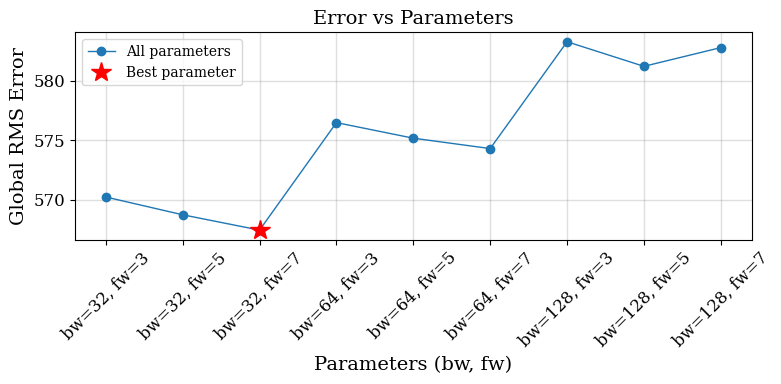

Processing file: /home/izm-ildana/astro/variable_search/data/M44_23-24.02.1987_11m_13S-2-6.fit


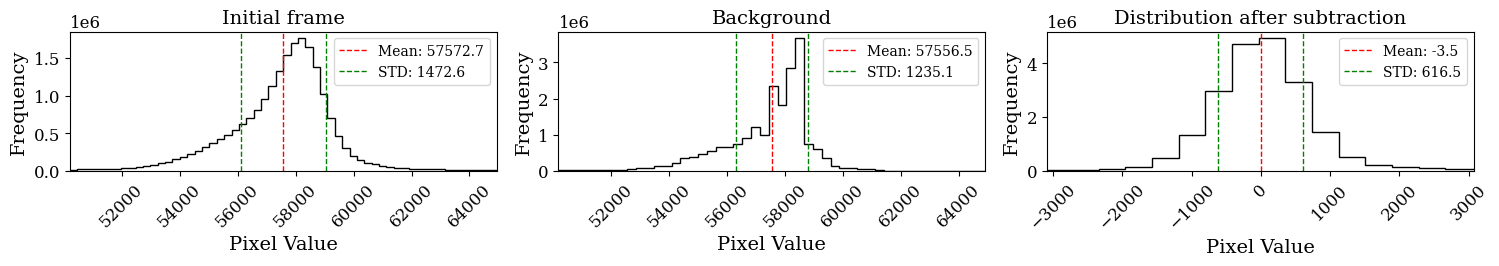

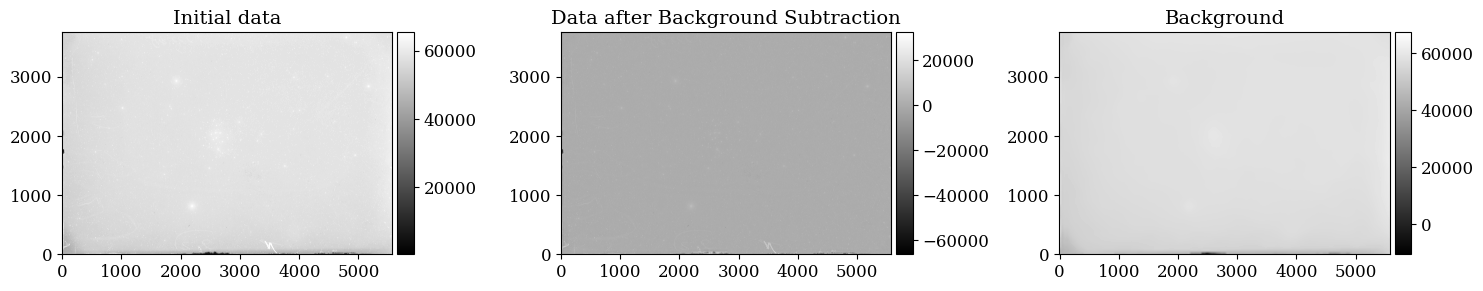

/tmp/ipykernel_65156/1028180206.py:408: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)
Processing files:  45%|███████████▋              | 9/20 [02:38<03:15, 17.74s/it]

4255 objects found in /home/izm-ildana/astro/variable_search/data/M44_23-24.02.1987_11m_13S-2-6.fit
RA max =  134.543
RA min =  125.132
DEC max =  22.732
DEC min =  16.759
Processed M44_23-24.02.1987_11m_13S-2-6.fit (9/20) in 18.23 seconds.
-------------------------------------------


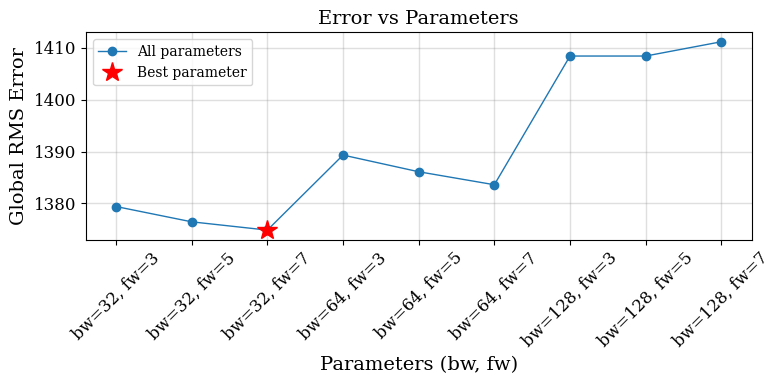

Processing file: /home/izm-ildana/astro/variable_search/data/NGC7000_05-06.09.1986_40m_63S-3-11.fit


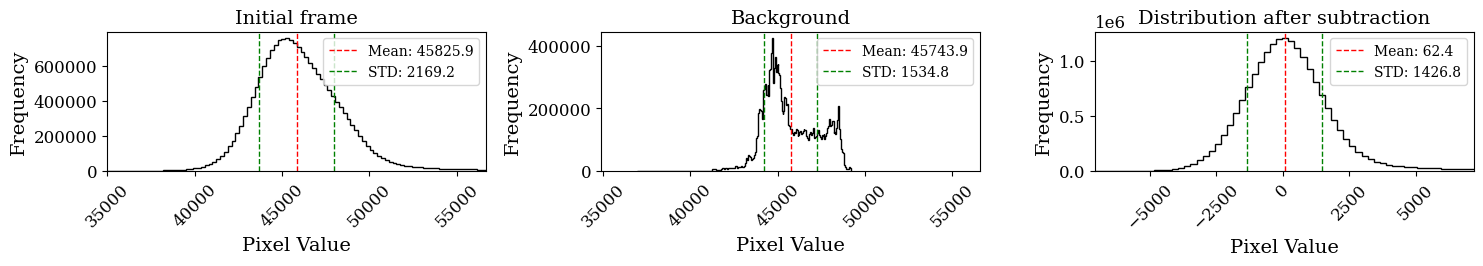

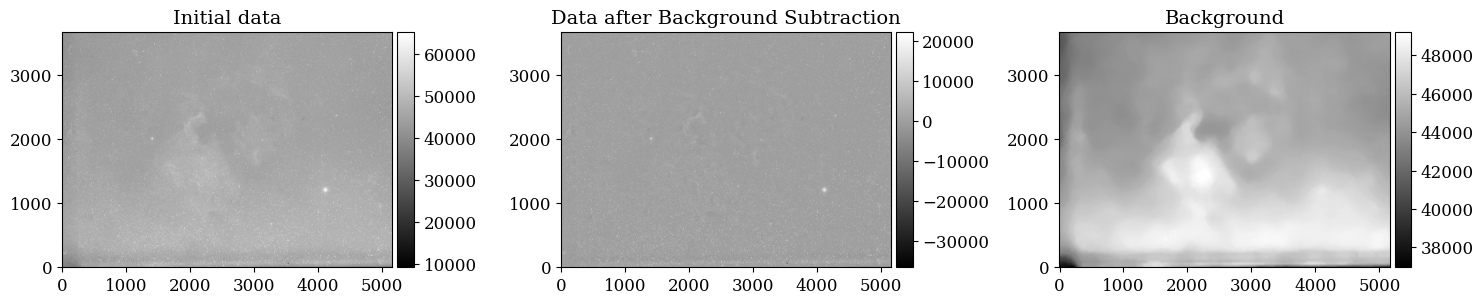

Processing files:  50%|████████████▌            | 10/20 [02:55<02:55, 17.56s/it]

4084 objects found in /home/izm-ildana/astro/variable_search/data/NGC7000_05-06.09.1986_40m_63S-3-11.fit
RA max =  319.669
RA min =  307.924
DEC max =  47.116
DEC min =  41.153
Processed NGC7000_05-06.09.1986_40m_63S-3-11.fit (10/20) in 17.14 seconds.
-------------------------------------------


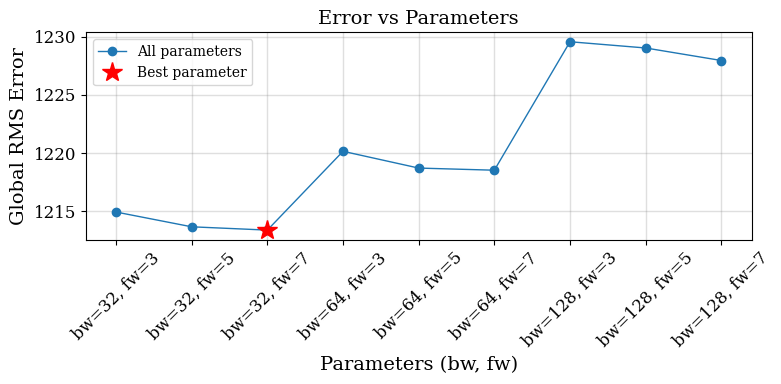

Processing file: /home/izm-ildana/astro/variable_search/data/Star_19-20.03.1977_5m_14K-83.fit


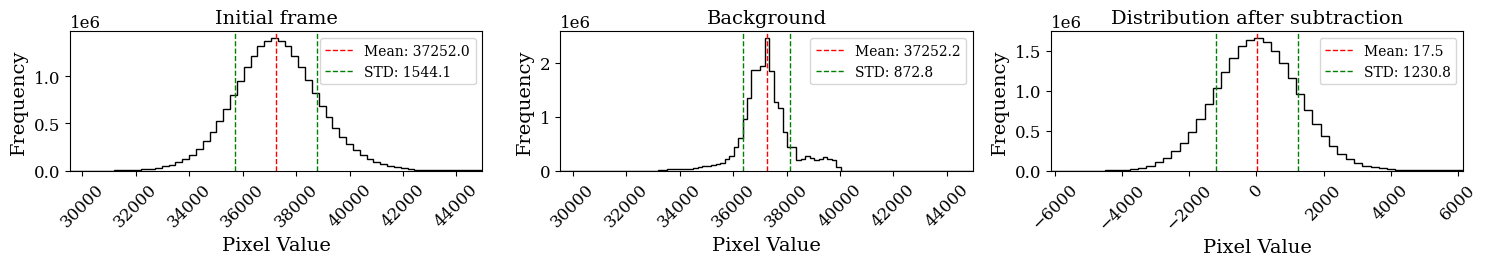

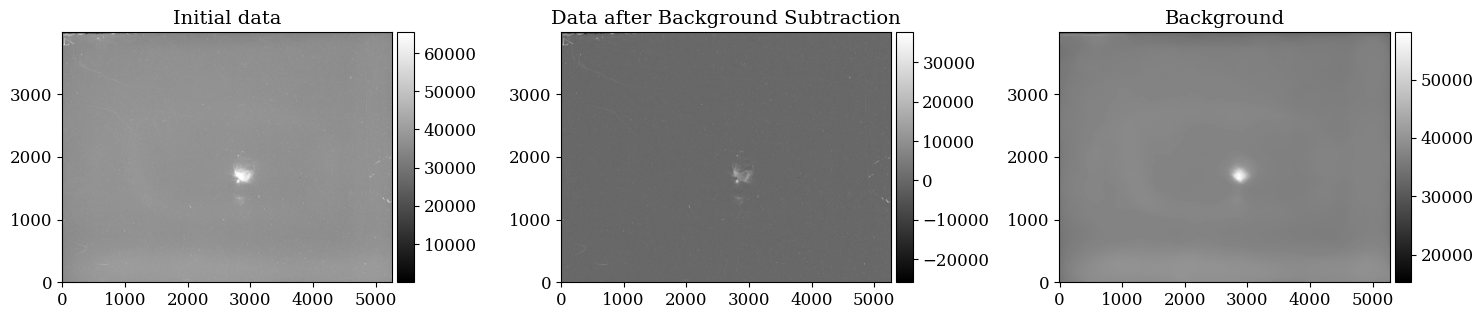

/tmp/ipykernel_65156/1028180206.py:408: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)
Processing files:  55%|█████████████▊           | 11/20 [03:12<02:37, 17.51s/it]

1044 objects found in /home/izm-ildana/astro/variable_search/data/Star_19-20.03.1977_5m_14K-83.fit
RA max =  88.309
RA min =  79.899
DEC max =  -2.683
DEC min =  -9.045
Processed Star_19-20.03.1977_5m_14K-83.fit (11/20) in 17.42 seconds.
-------------------------------------------


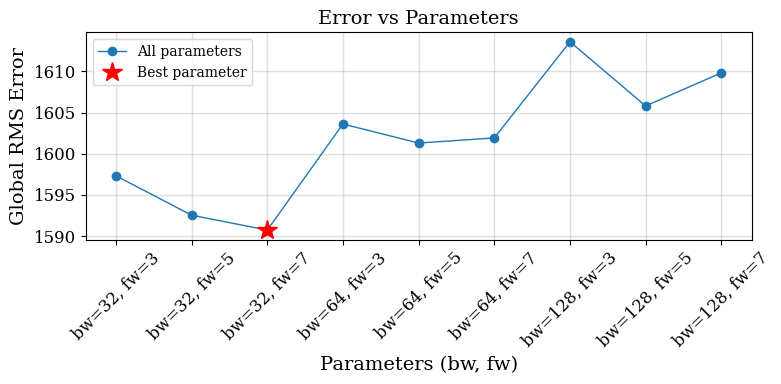

Processing file: /home/izm-ildana/astro/variable_search/data/alf-Cyg_20-21.10.1985_20m_77S-77986.fit


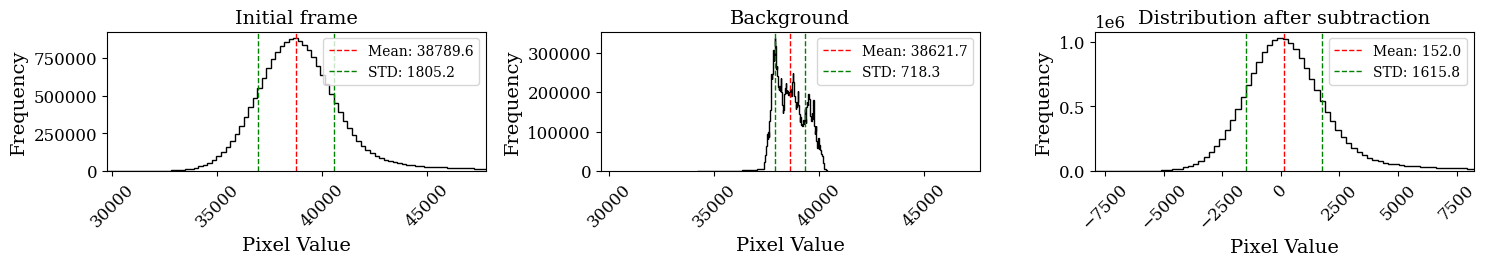

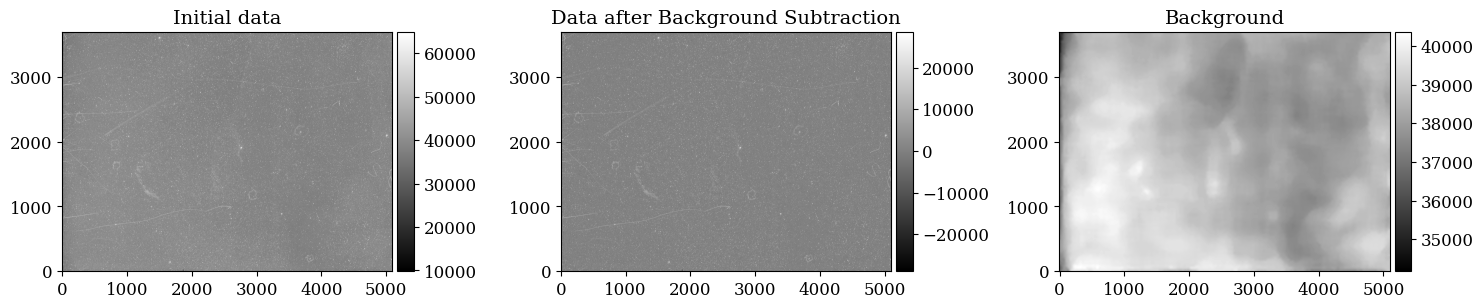

/tmp/ipykernel_65156/1028180206.py:408: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)
Processing files:  60%|███████████████          | 12/20 [03:29<02:18, 17.37s/it]

5317 objects found in /home/izm-ildana/astro/variable_search/data/alf-Cyg_20-21.10.1985_20m_77S-77986.fit
RA max =  316.587
RA min =  307.035
DEC max =  33.612
DEC min =  27.817
Processed alf-Cyg_20-21.10.1985_20m_77S-77986.fit (12/20) in 17.03 seconds.
-------------------------------------------


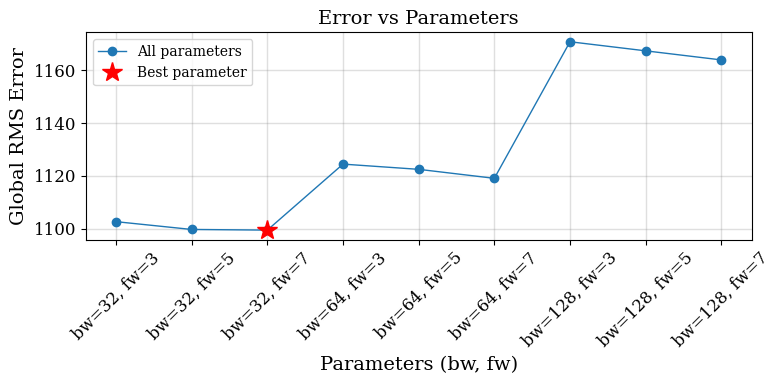

Processing file: /home/izm-ildana/astro/variable_search/data/IC1396_12-13.04.1980_1h_14K-209.fit


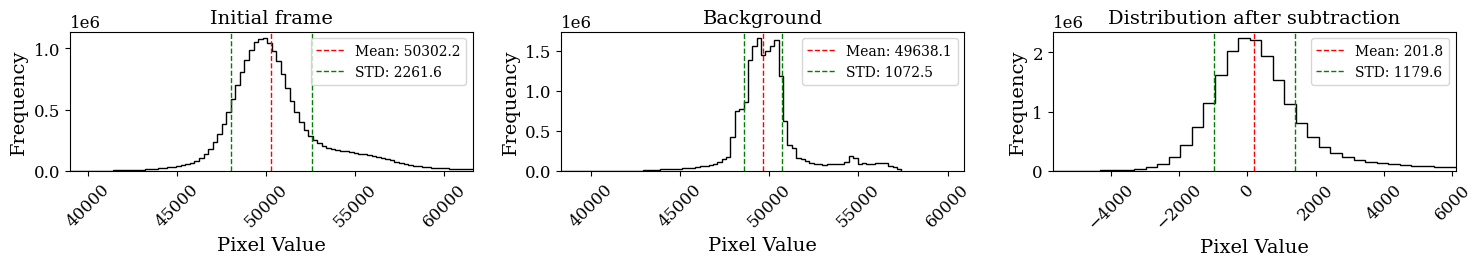

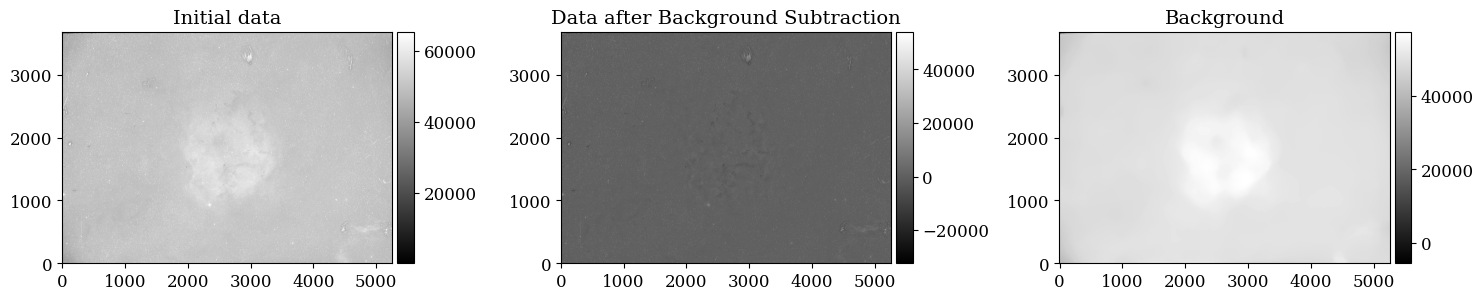

Processing files:  65%|████████████████▎        | 13/20 [03:47<02:02, 17.52s/it]

7094 objects found in /home/izm-ildana/astro/variable_search/data/IC1396_12-13.04.1980_1h_14K-209.fit
RA max =  333.26
RA min =  316.826
DEC max =  60.094
DEC min =  54.186
Processed IC1396_12-13.04.1980_1h_14K-209.fit (13/20) in 17.87 seconds.
-------------------------------------------


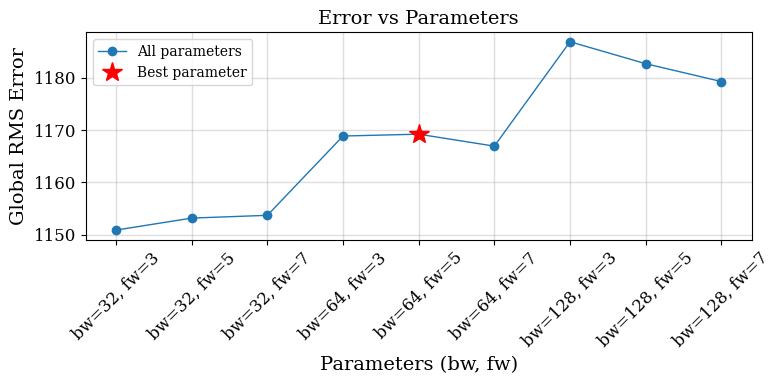

Processing file: /home/izm-ildana/astro/variable_search/data/Star_11-12.11.1977_1h_2K-129.fit


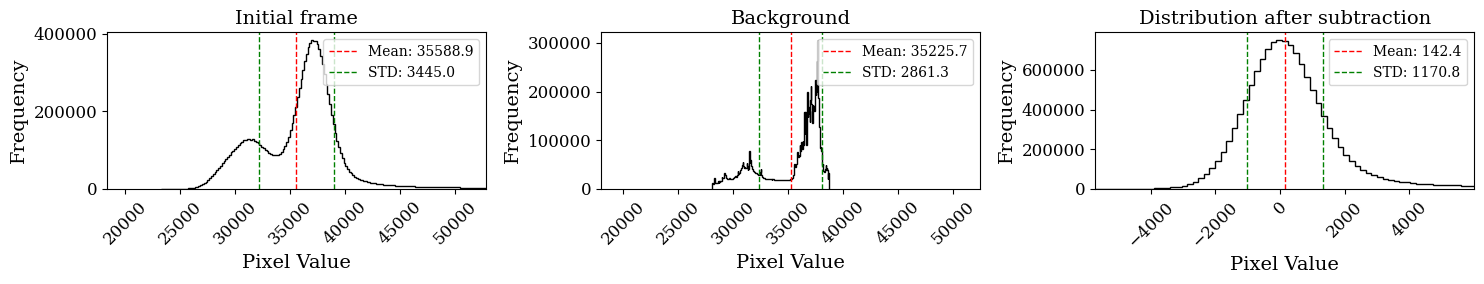

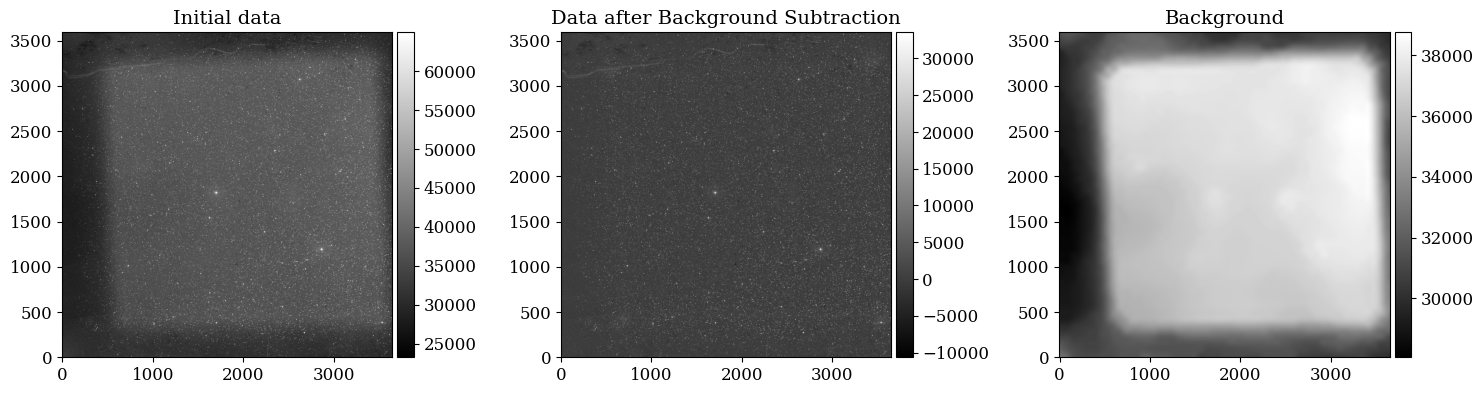

Processing files:  70%|█████████████████▌       | 14/20 [04:01<01:37, 16.24s/it]

8092 objects found in /home/izm-ildana/astro/variable_search/data/Star_11-12.11.1977_1h_2K-129.fit
RA max =  349.334
RA min =  341.257
DEC max =  45.135
DEC min =  39.436
Processed Star_11-12.11.1977_1h_2K-129.fit (14/20) in 13.28 seconds.
-------------------------------------------


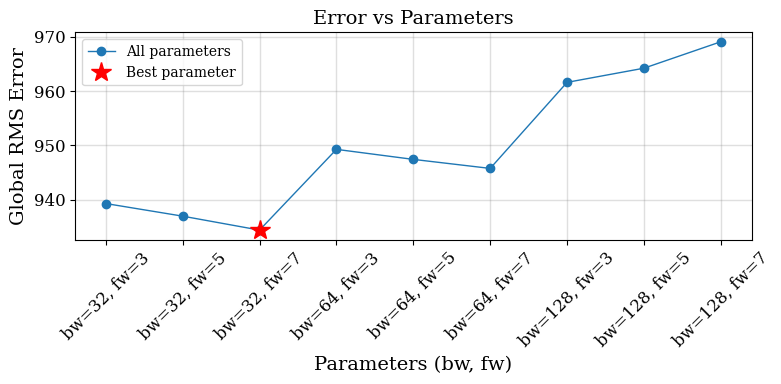

Processing file: /home/izm-ildana/astro/variable_search/data/sky_21-22.09.1987_10m_5S-3-9.fit


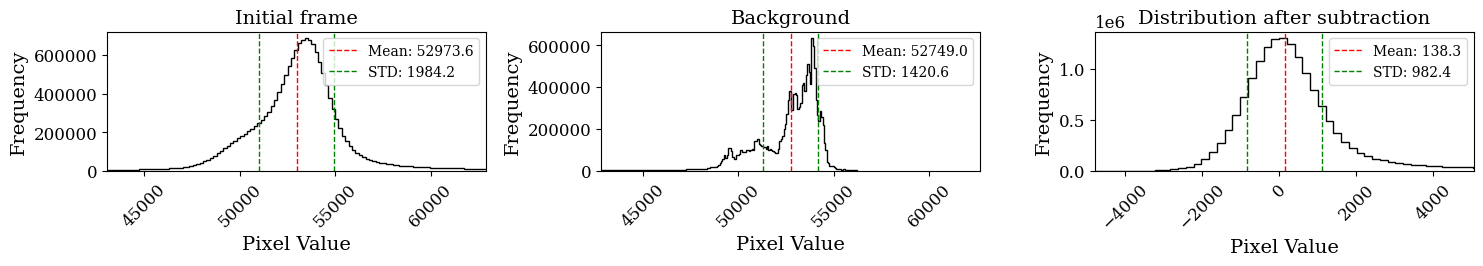

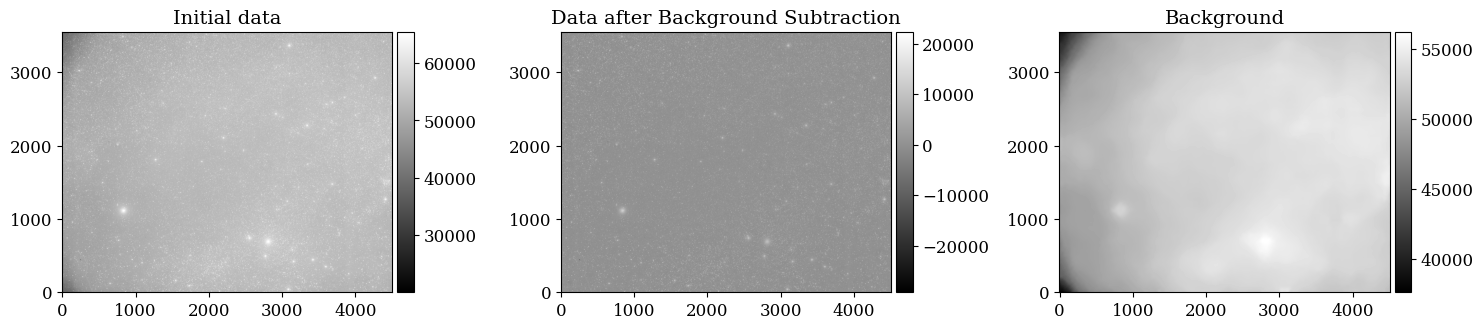

Processing files:  75%|██████████████████▊      | 15/20 [04:17<01:21, 16.21s/it]

7866 objects found in /home/izm-ildana/astro/variable_search/data/sky_21-22.09.1987_10m_5S-3-9.fit
RA max =  355.453
RA min =  341.328
DEC max =  60.456
DEC min =  54.611
Processed sky_21-22.09.1987_10m_5S-3-9.fit (15/20) in 16.12 seconds.
-------------------------------------------


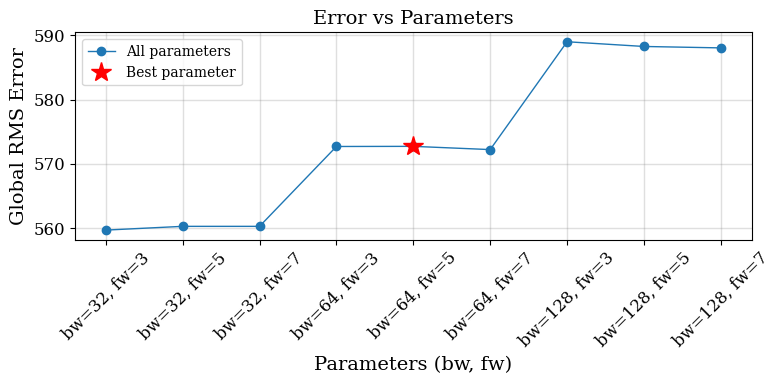

Processing file: /home/izm-ildana/astro/variable_search/data/sky_22-23.09.1987_10m_4S-2-10.fit


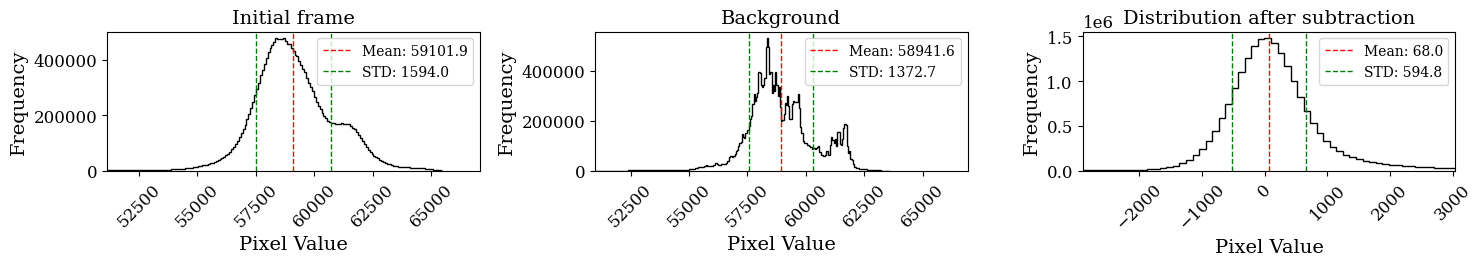

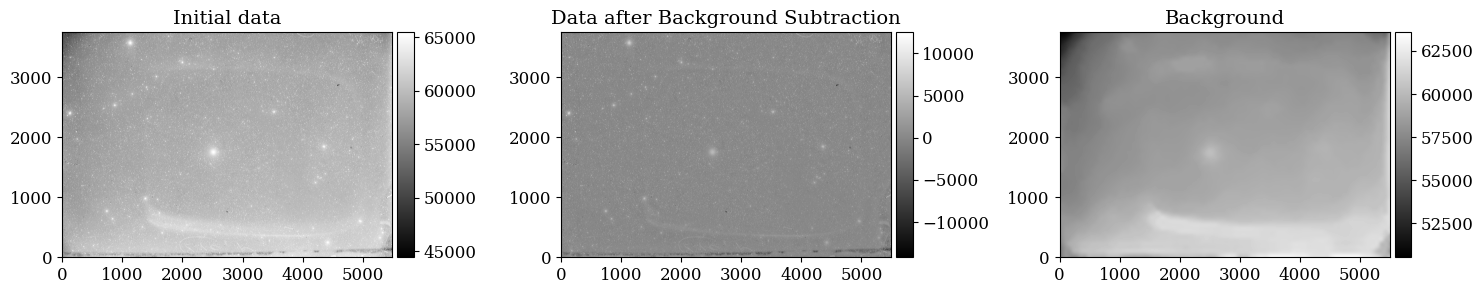

Processing files:  80%|████████████████████     | 16/20 [04:36<01:08, 17.07s/it]

5670 objects found in /home/izm-ildana/astro/variable_search/data/sky_22-23.09.1987_10m_4S-2-10.fit
RA max =  343.313
RA min =  331.033
DEC max =  45.728
DEC min =  39.811
Processed sky_22-23.09.1987_10m_4S-2-10.fit (16/20) in 19.09 seconds.
-------------------------------------------


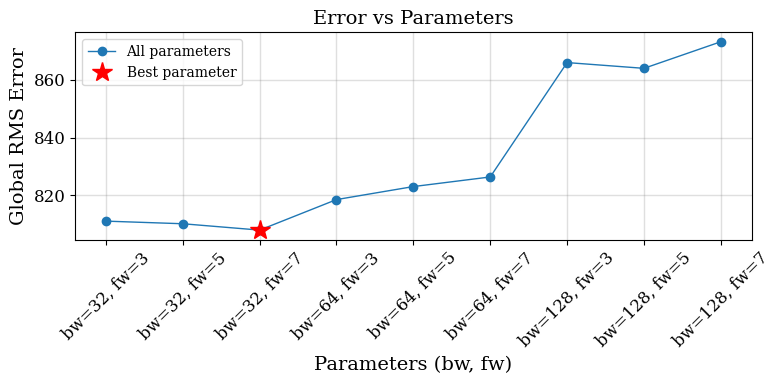

Processing file: /home/izm-ildana/astro/variable_search/data/alf-Cyg_11-12.11.1985_40m_70S-1.fit


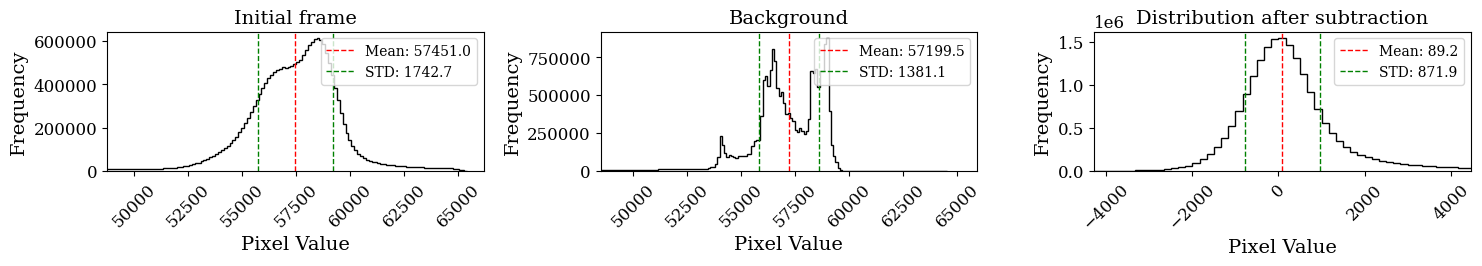

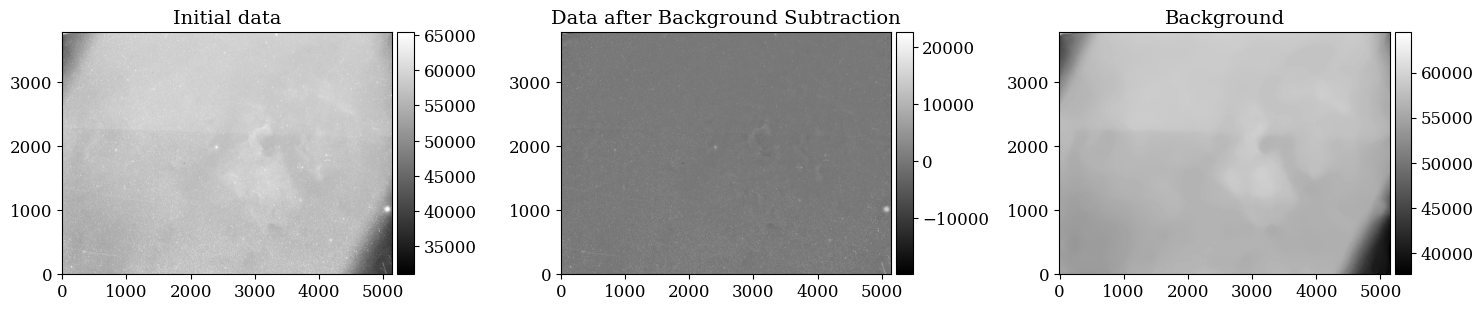

Processing files:  85%|█████████████████████▎   | 17/20 [04:55<00:53, 17.71s/it]

5434 objects found in /home/izm-ildana/astro/variable_search/data/alf-Cyg_11-12.11.1985_40m_70S-1.fit
RA max =  321.724
RA min =  310.003
DEC max =  46.89
DEC min =  40.958
Processed alf-Cyg_11-12.11.1985_40m_70S-1.fit (17/20) in 19.19 seconds.
-------------------------------------------


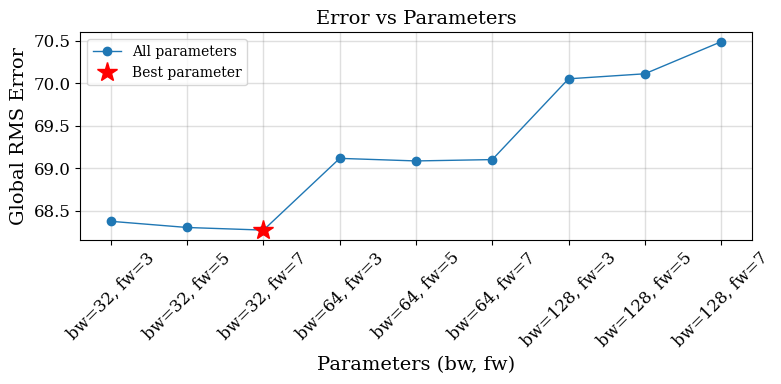

Processing file: /home/izm-ildana/astro/variable_search/data/M45___36S-2-7.fit


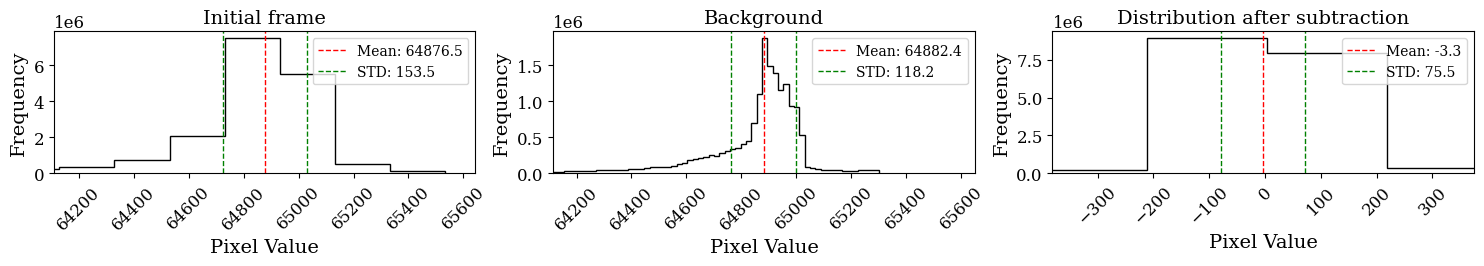

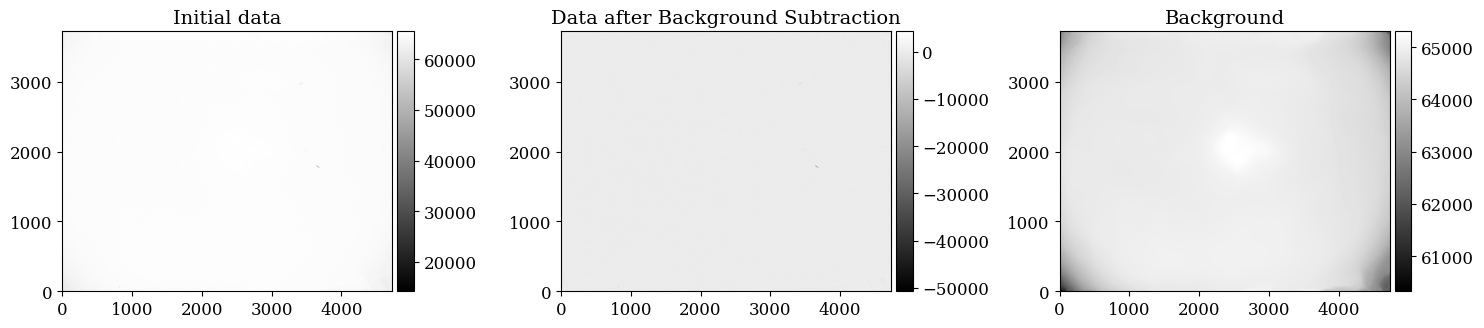

/tmp/ipykernel_65156/1028180206.py:408: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)
Processing files:  90%|██████████████████████▌  | 18/20 [05:11<00:34, 17.08s/it]

2923 objects found in /home/izm-ildana/astro/variable_search/data/M45___36S-2-7.fit
RA max =  60.497
RA min =  52.165
DEC max =  26.902
DEC min =  20.789
Processed M45___36S-2-7.fit (18/20) in 15.60 seconds.
-------------------------------------------


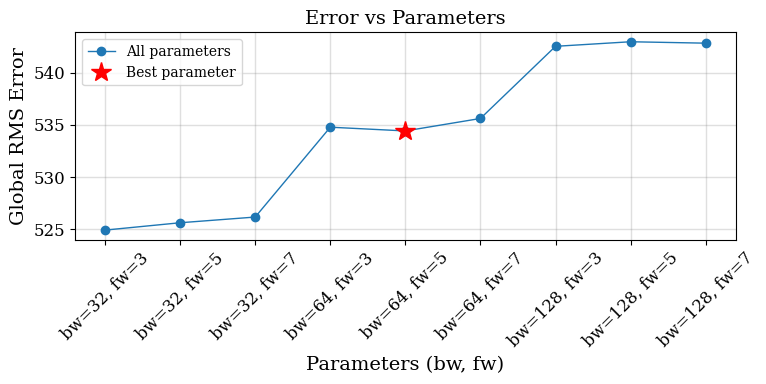

Processing file: /home/izm-ildana/astro/variable_search/data/IC2118_20-21.01.1979_6m_11K-175.fit


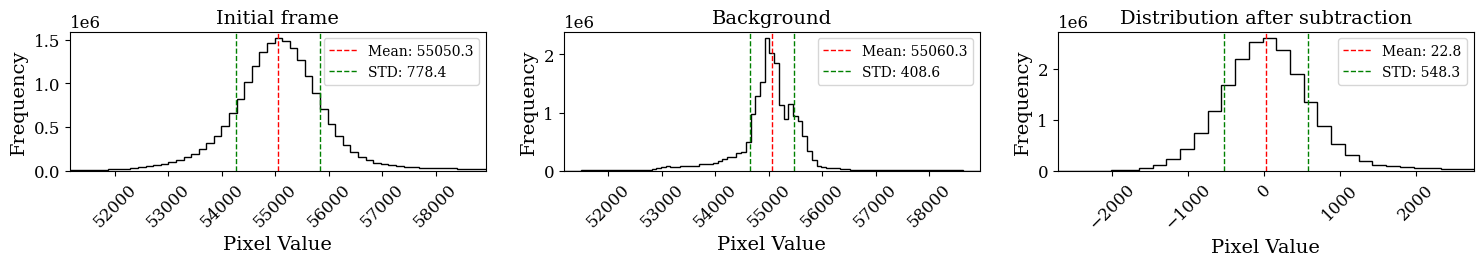

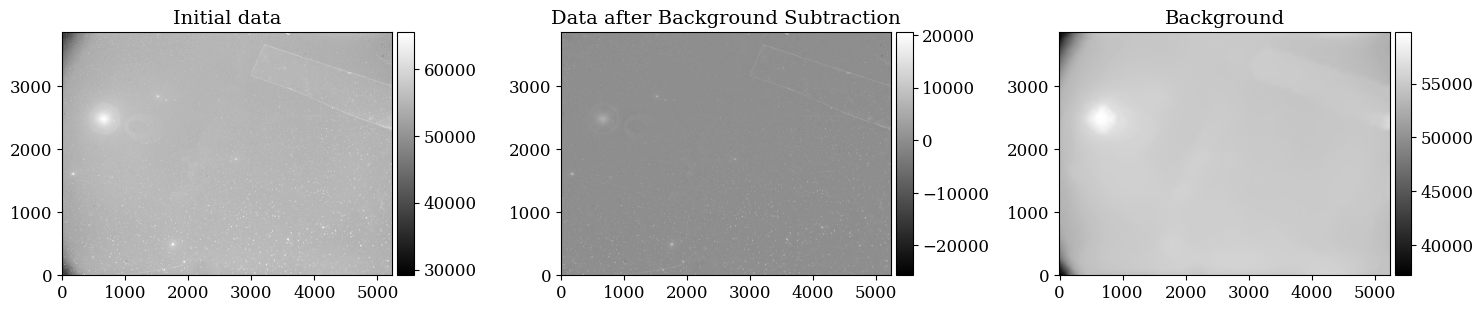

/tmp/ipykernel_65156/1028180206.py:408: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)
Processing files:  95%|███████████████████████▊ | 19/20 [05:29<00:17, 17.34s/it]

3778 objects found in /home/izm-ildana/astro/variable_search/data/IC2118_20-21.01.1979_6m_11K-175.fit
RA max =  79.707
RA min =  71.426
DEC max =  -4.206
DEC min =  -10.39
Processed IC2118_20-21.01.1979_6m_11K-175.fit (19/20) in 17.94 seconds.
-------------------------------------------


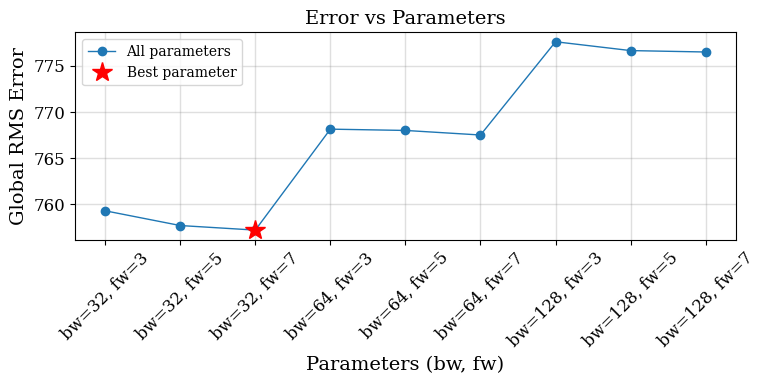

Processing file: /home/izm-ildana/astro/variable_search/data/M44_24-25.02.1987_9m_14S-2-1.fit


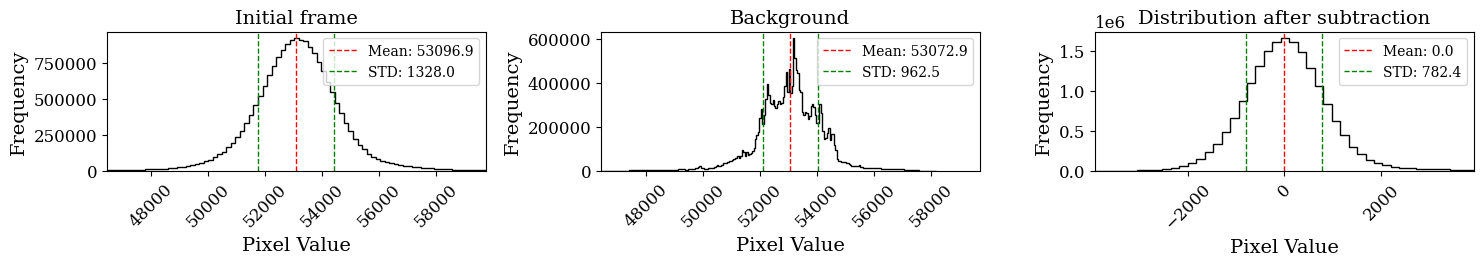

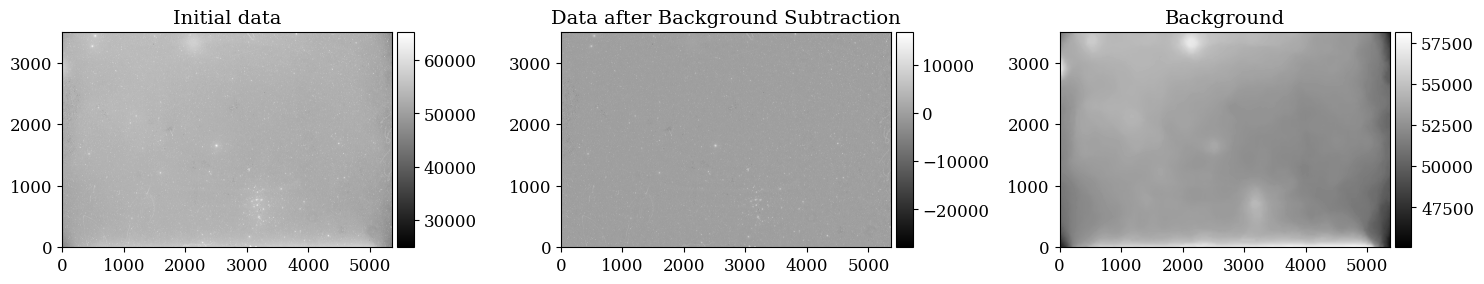

Processing files: 100%|█████████████████████████| 20/20 [05:45<00:00, 17.27s/it]

2914 objects found in /home/izm-ildana/astro/variable_search/data/M44_24-25.02.1987_9m_14S-2-1.fit
RA max =  135.384
RA min =  126.409
DEC max =  20.717
DEC min =  15.18
Processed M44_24-25.02.1987_9m_14S-2-1.fit (20/20) in 16.40 seconds.
-------------------------------------------


NameError: name 'ra_diff_global' is not defined

In [5]:
process_directory(fits_directory, output_directory,scale='zscale')

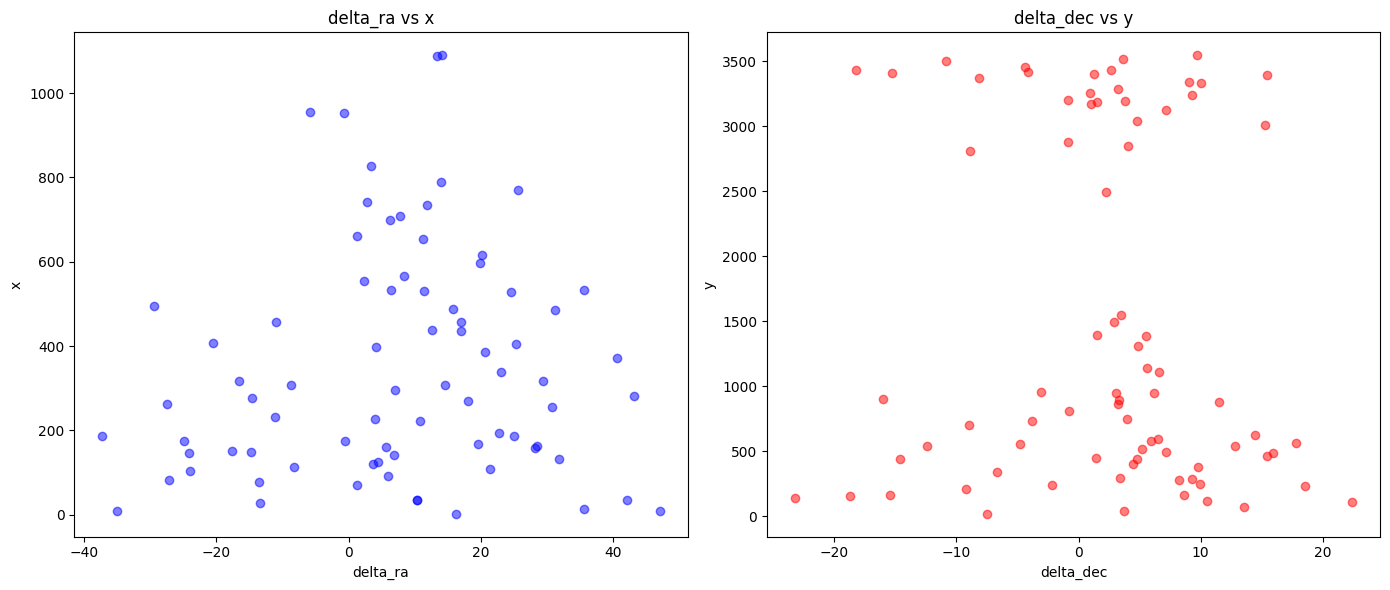

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: sky_21-22.09.1987_10m_5S-3-9_top78_gaia_27arcsec.fits


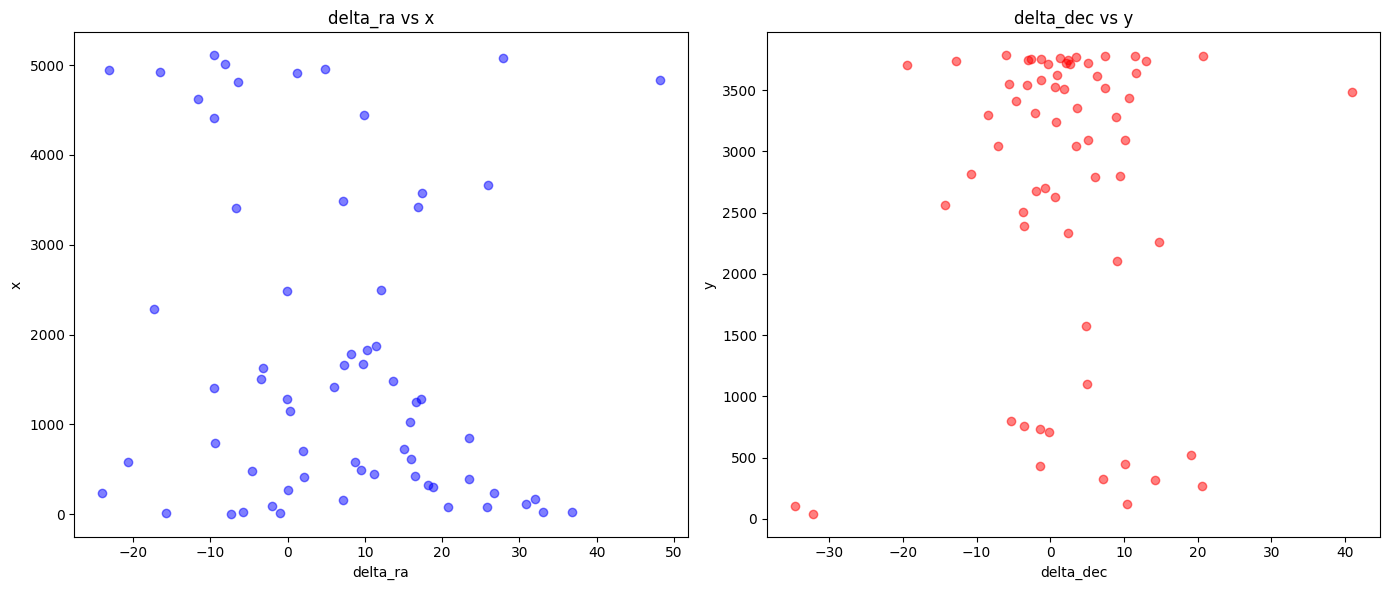

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: IC1396_07-08.04.1980_60m_14K-208_top65_gaia_42arcsec.fits


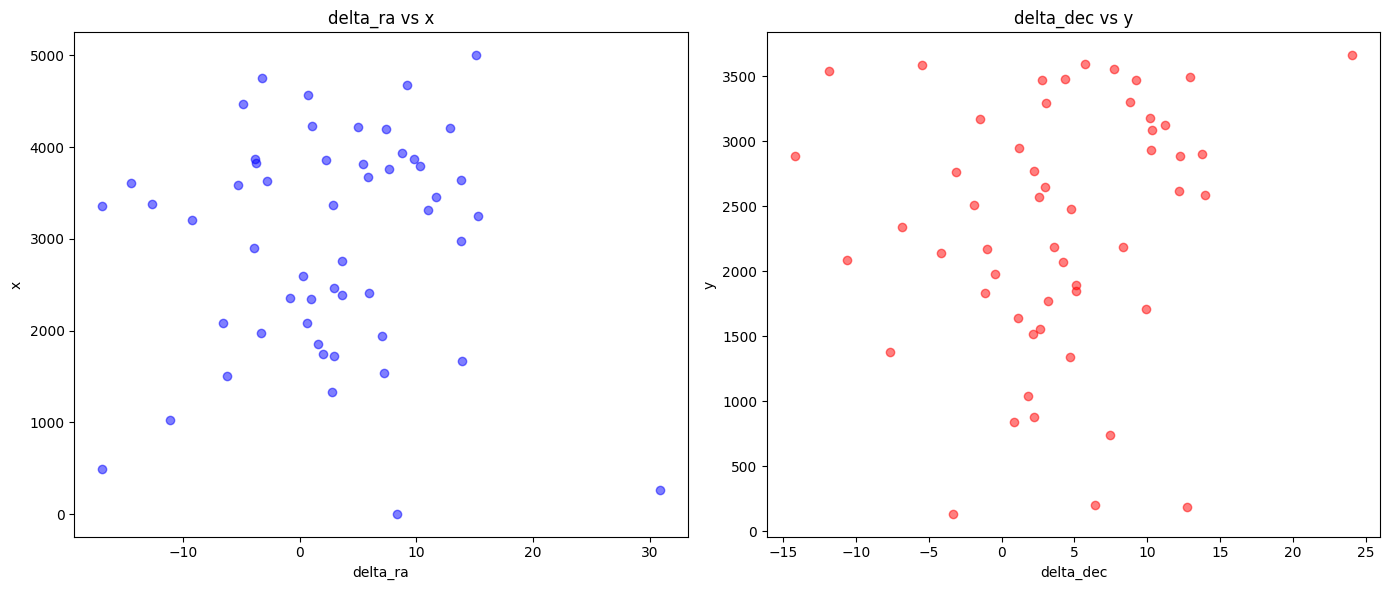

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: alf-Cyg_20-21.10.1985_20m_77S-77986_top53_gaia_31arcsec.fits


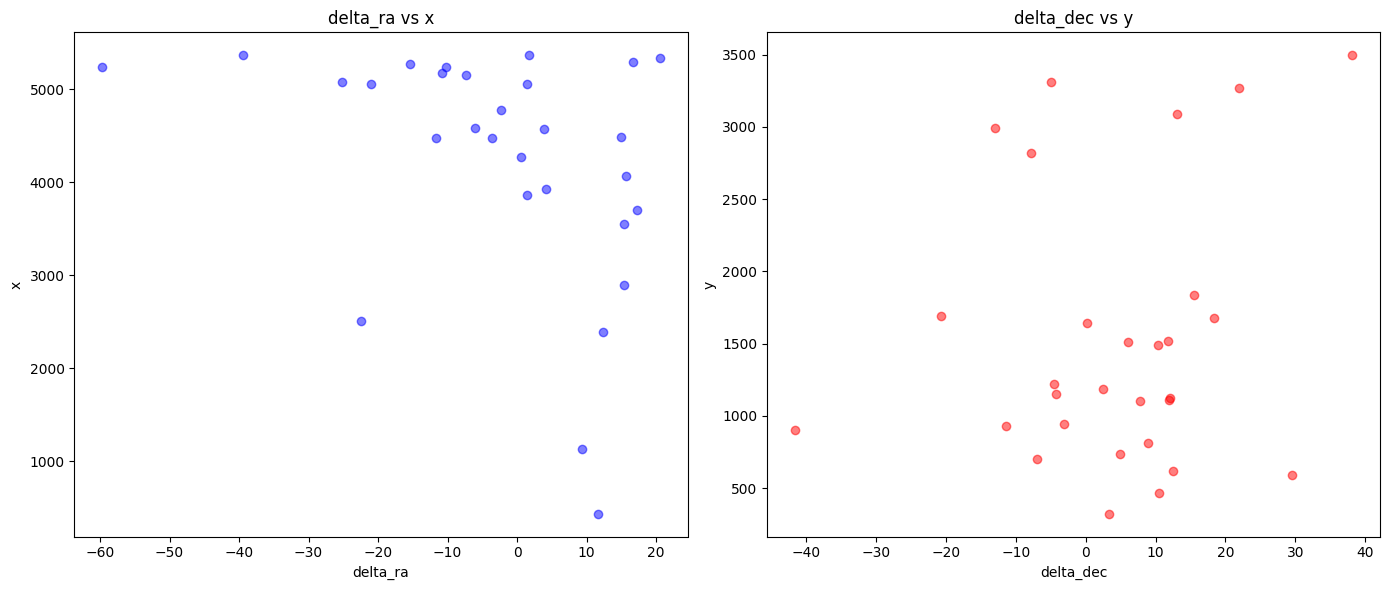

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: M44_24-25.02.1987_9m_14S-2-1_top29_gaia_59arcsec.fits


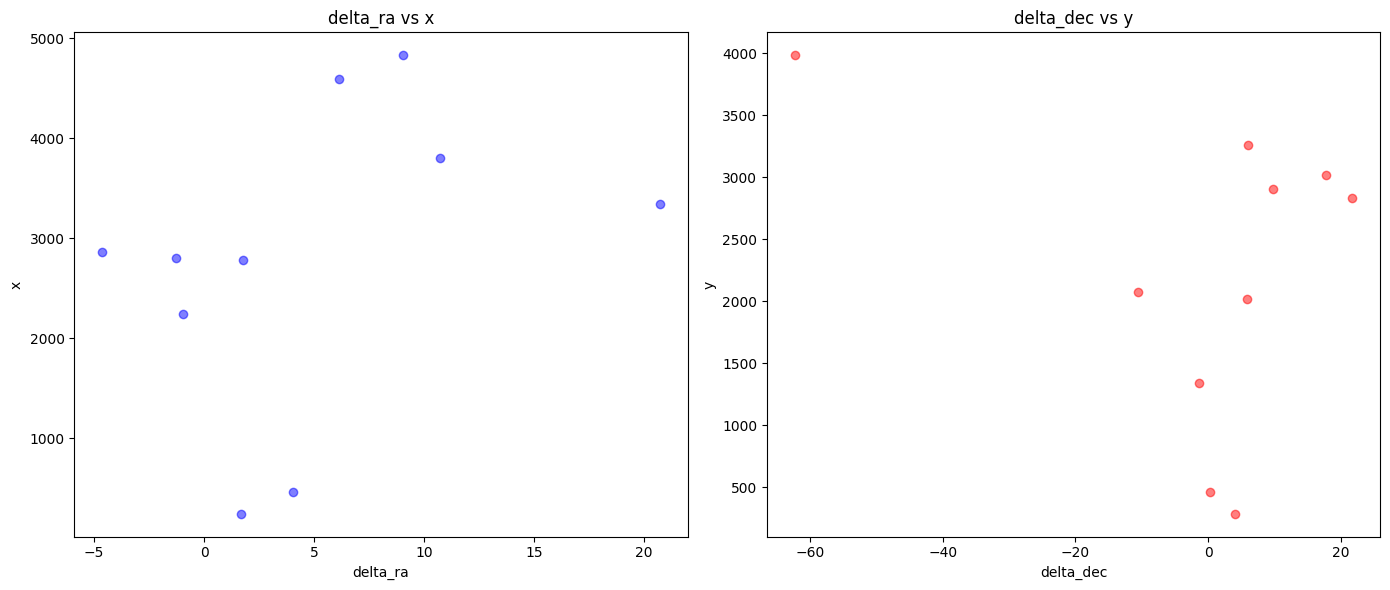

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: Star_19-20.03.1977_5m_14K-83_top10_gaia_63arcsec.fits


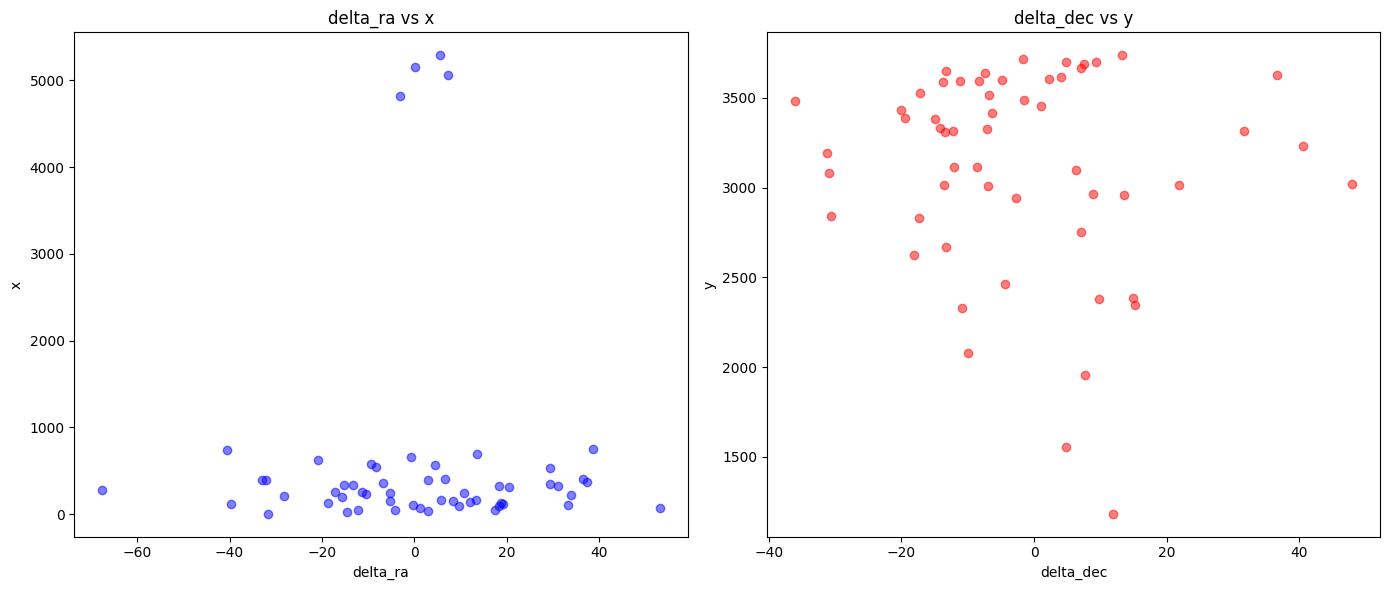

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: sky_22-23.09.1987_10m_4S-2-10_top56_gaia_60arcsec.fits


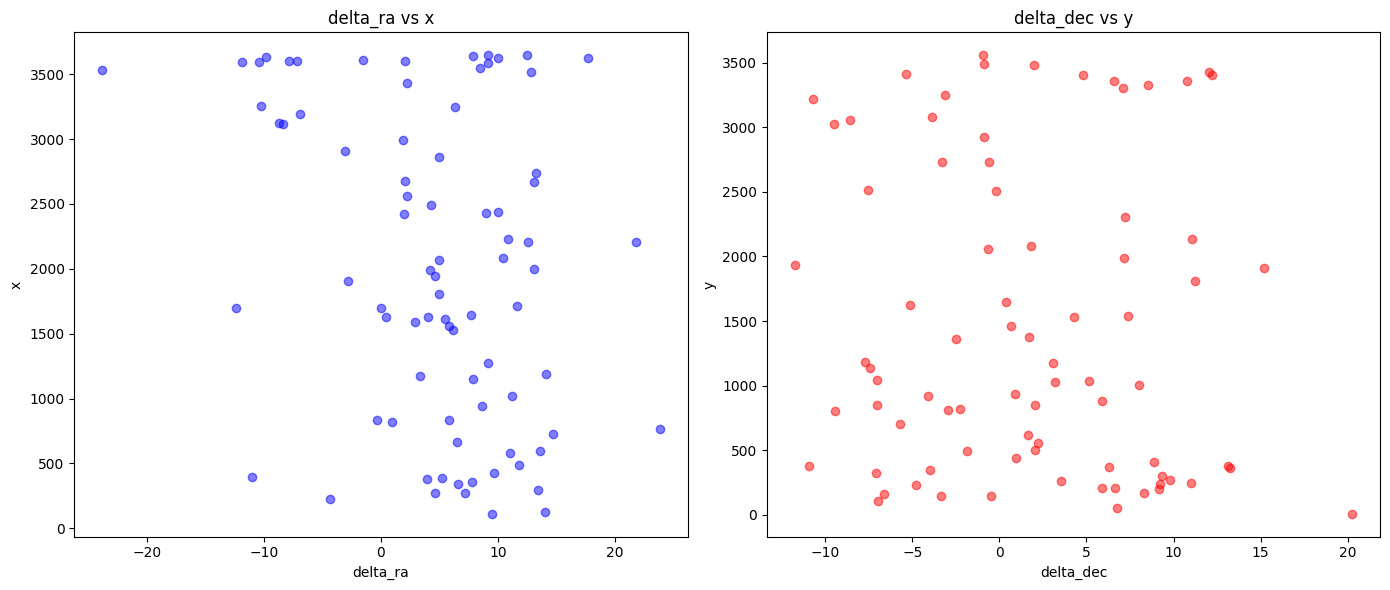

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: Star_11-12.11.1977_1h_2K-129_top80_gaia_27arcsec.fits


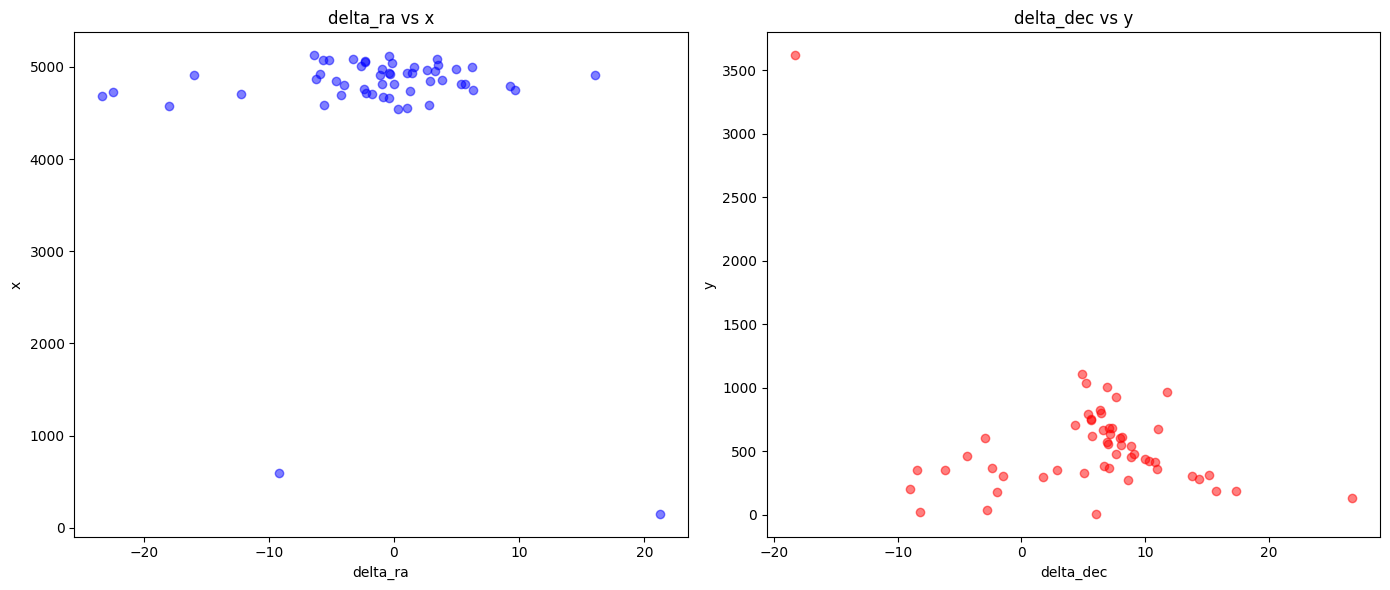

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: alf-Cyg_11-12.11.1985_40m_70S-1_top54_gaia_30arcsec.fits


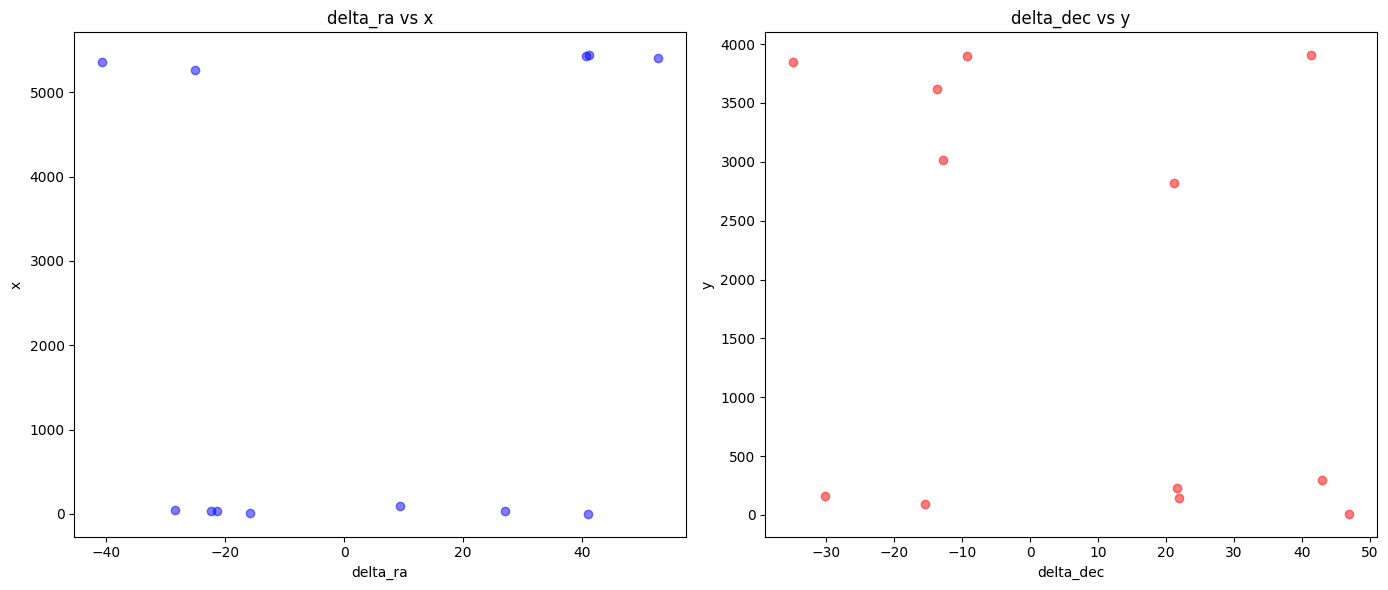

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: Pleiades_28-29.11.1981__14K-250_top12_gaia_63arcsec.fits


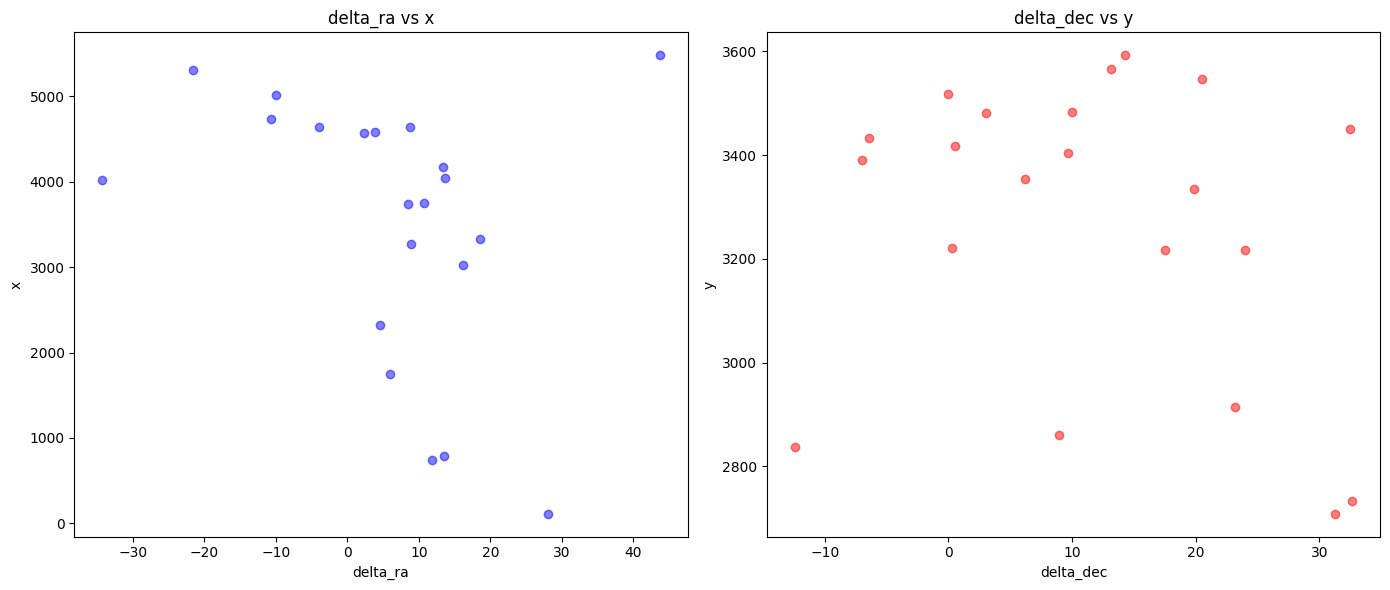

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: M44_24-25.02.1987_8m_14S-3-1_top21_gaia_47arcsec.fits


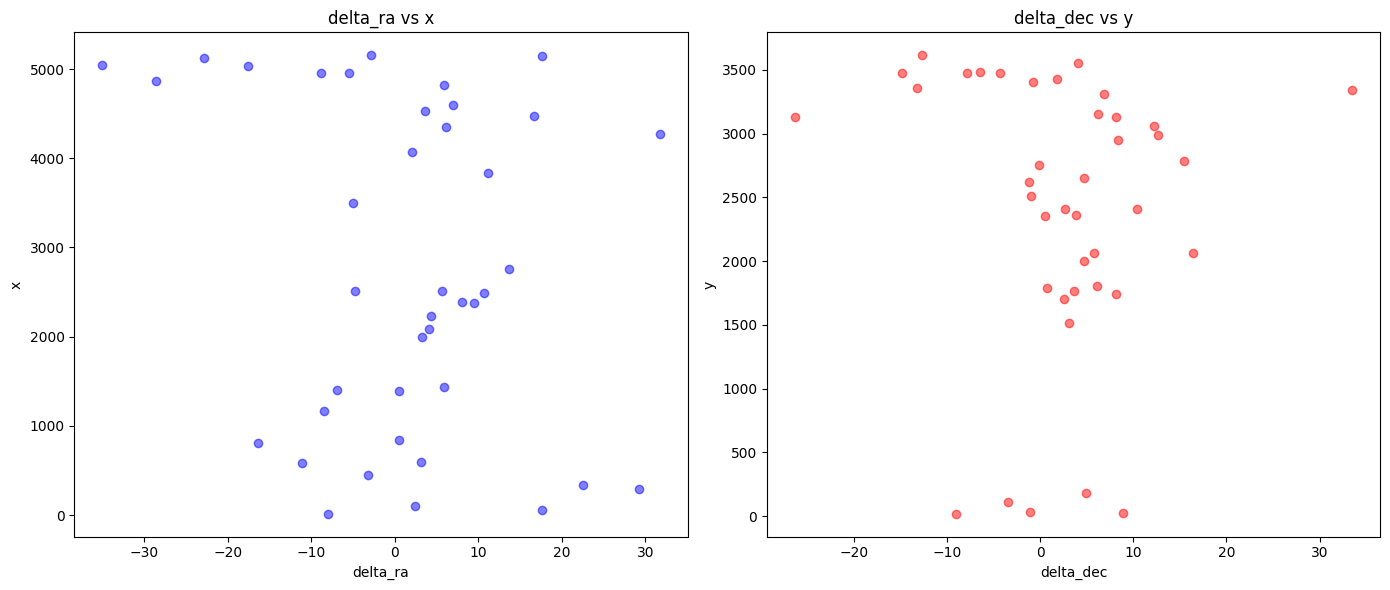

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: NGC7000_05-06.09.1986_40m_63S-3-11_top40_gaia_34arcsec.fits


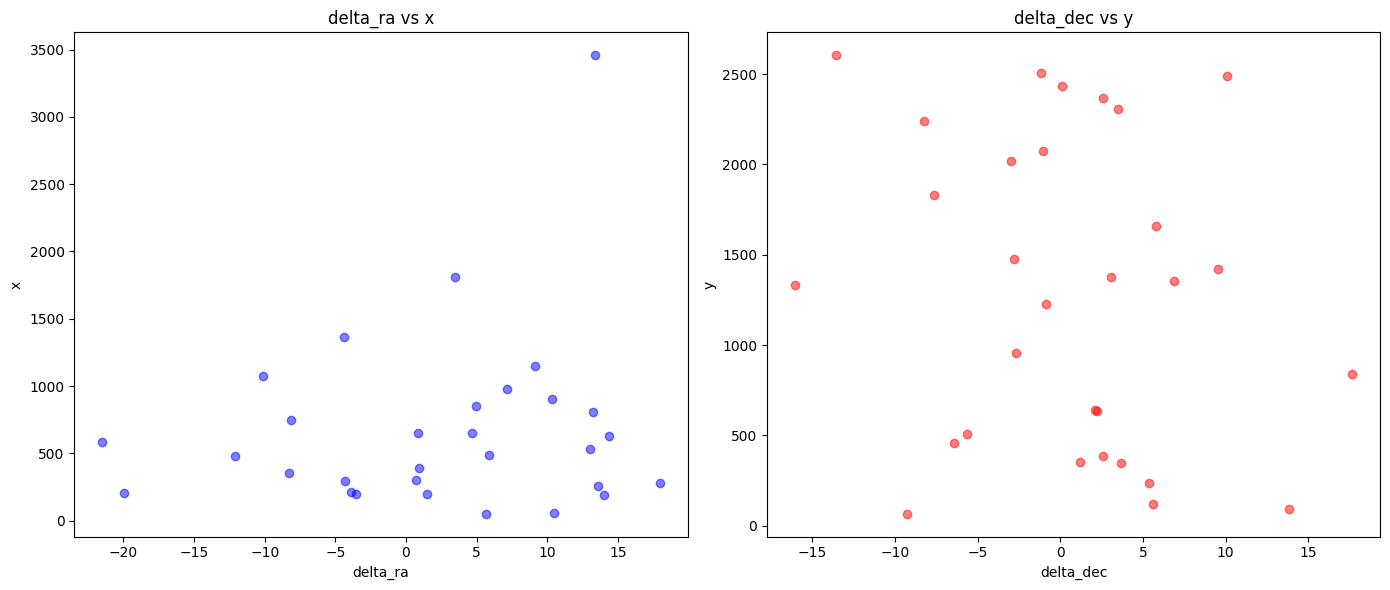

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: alf-Cyg_11-12.11.1985_40m_70S-4_top30_gaia_19arcsec.fits


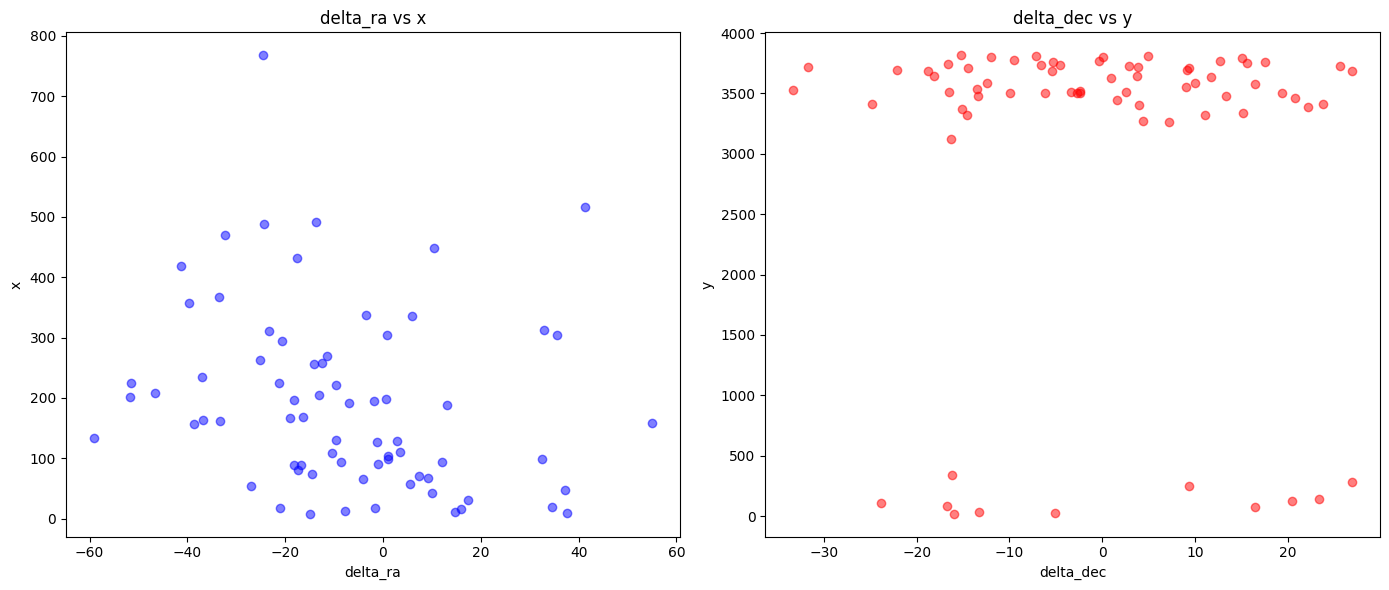

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: Star_15-16.06.1988_10m_38S-3-5_top71_gaia_42arcsec.fits


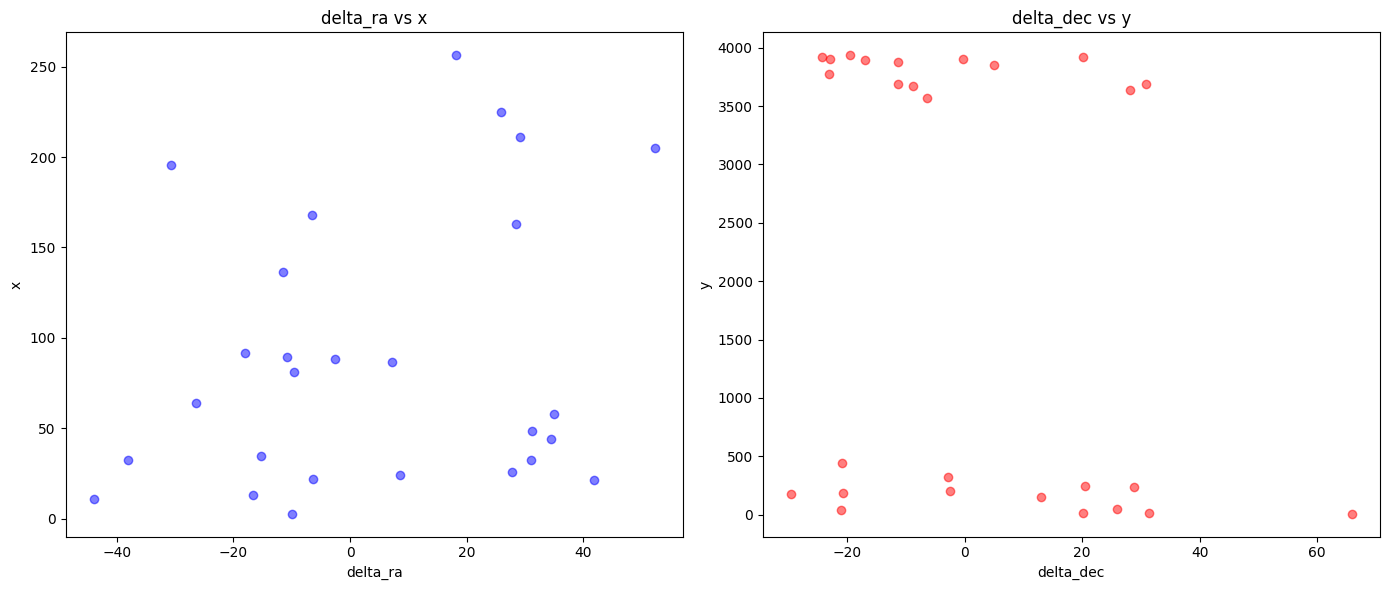

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: Nebula_03-04.11.1991_20m_14K-0_top27_gaia_81arcsec.fits


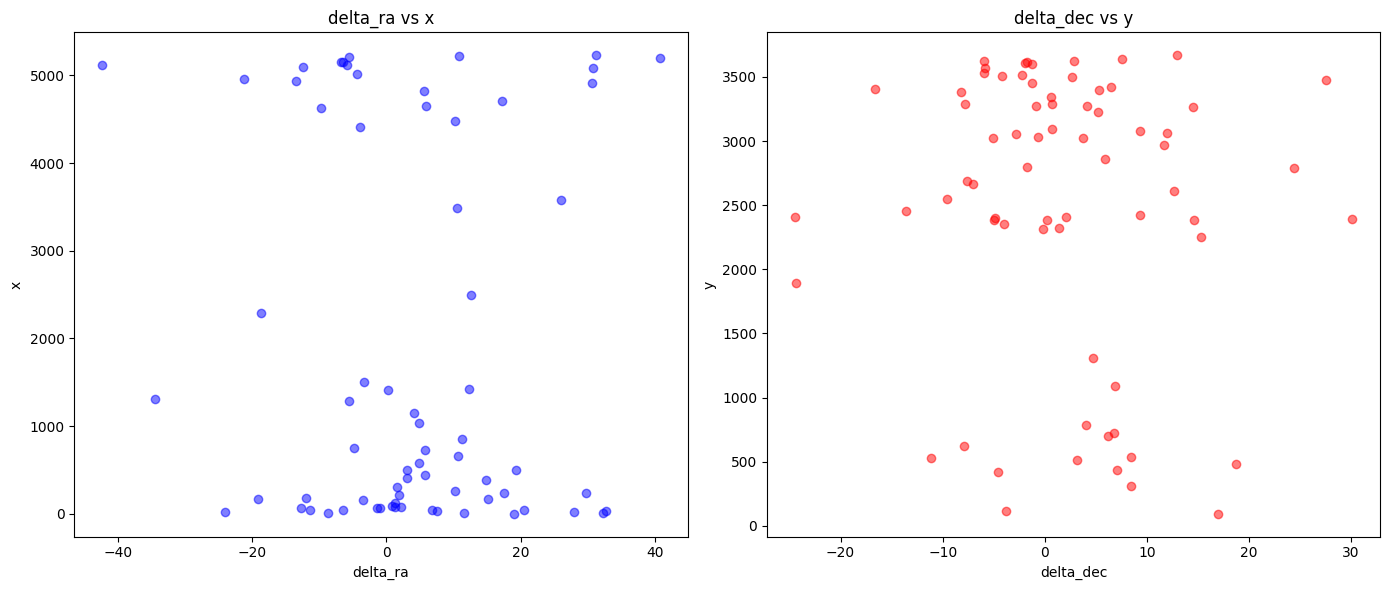

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: IC1396_12-13.04.1980_1h_14K-209_top70_gaia_31arcsec.fits


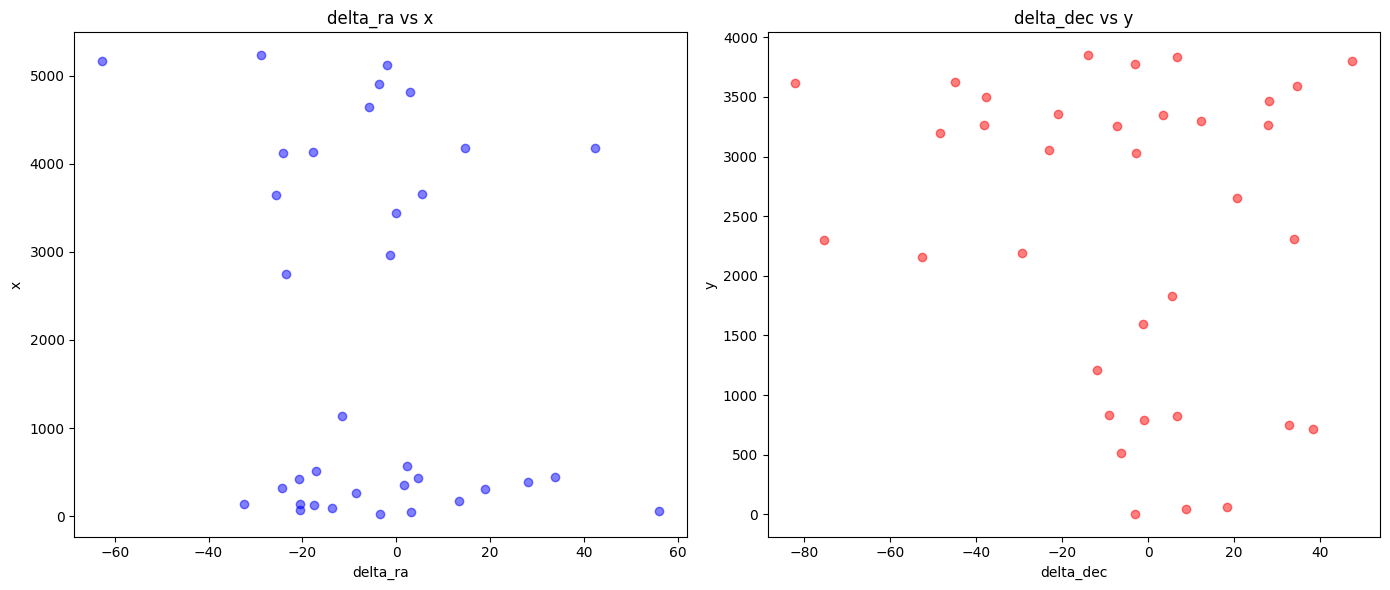

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: IC2118_20-21.01.1979_6m_11K-175_top37_gaia_82arcsec.fits


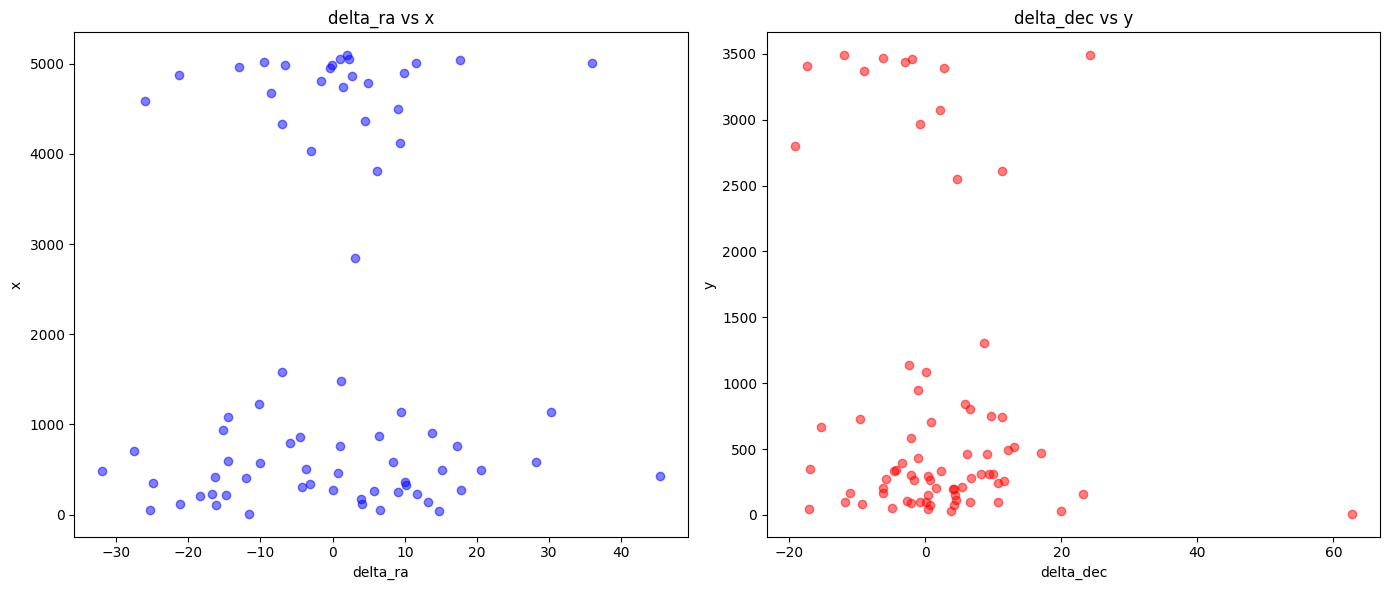

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: sky_21-22.09.1987_10.5m_5S-2-9_top74_gaia_66arcsec.fits


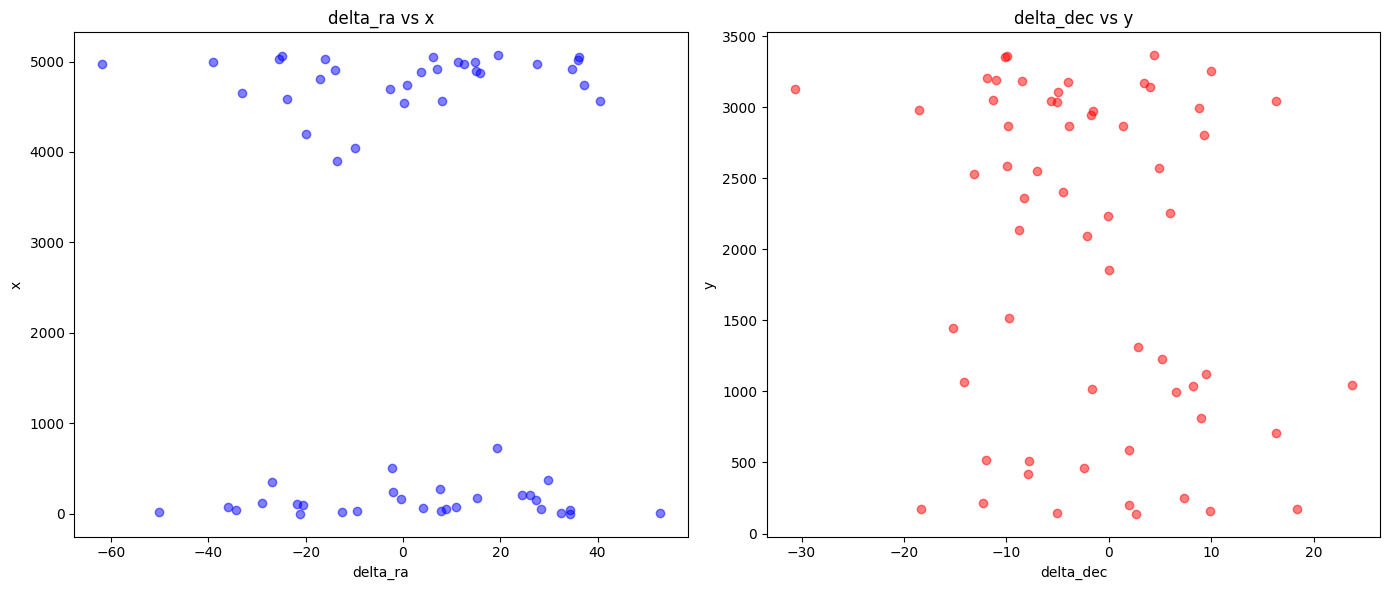

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: sky_21-22.09.1987_10m_5S-2-10_top60_gaia_31arcsec.fits


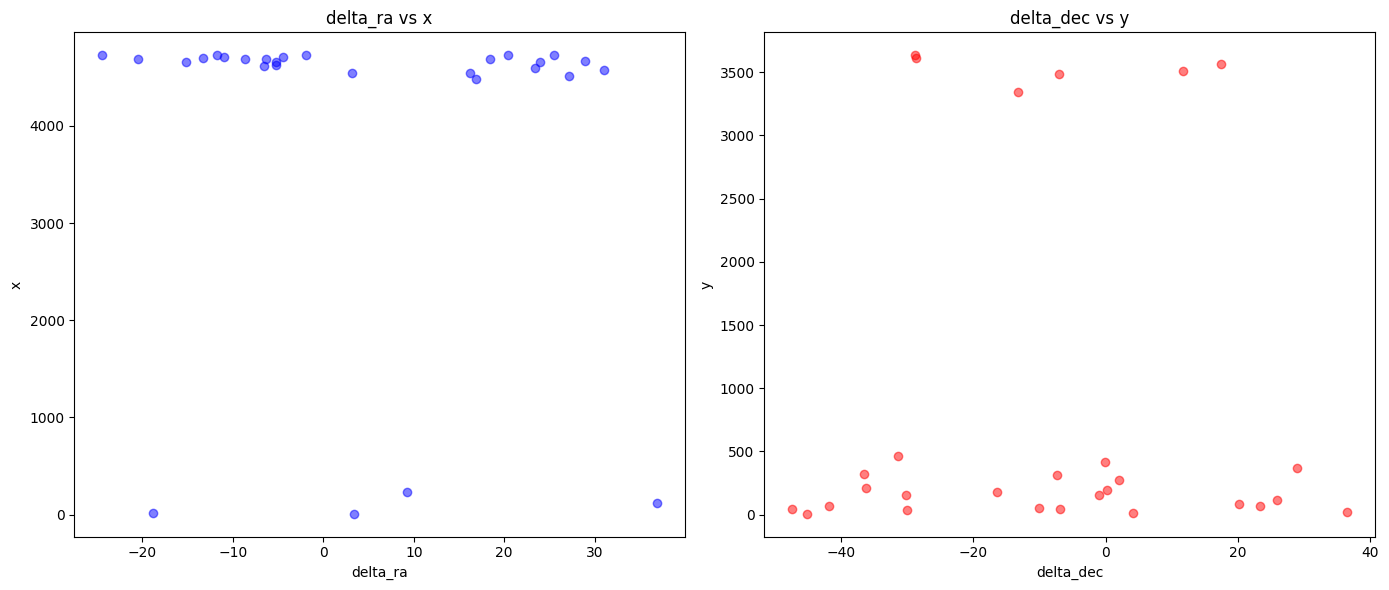

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: M45___36S-2-7_top29_gaia_55arcsec.fits


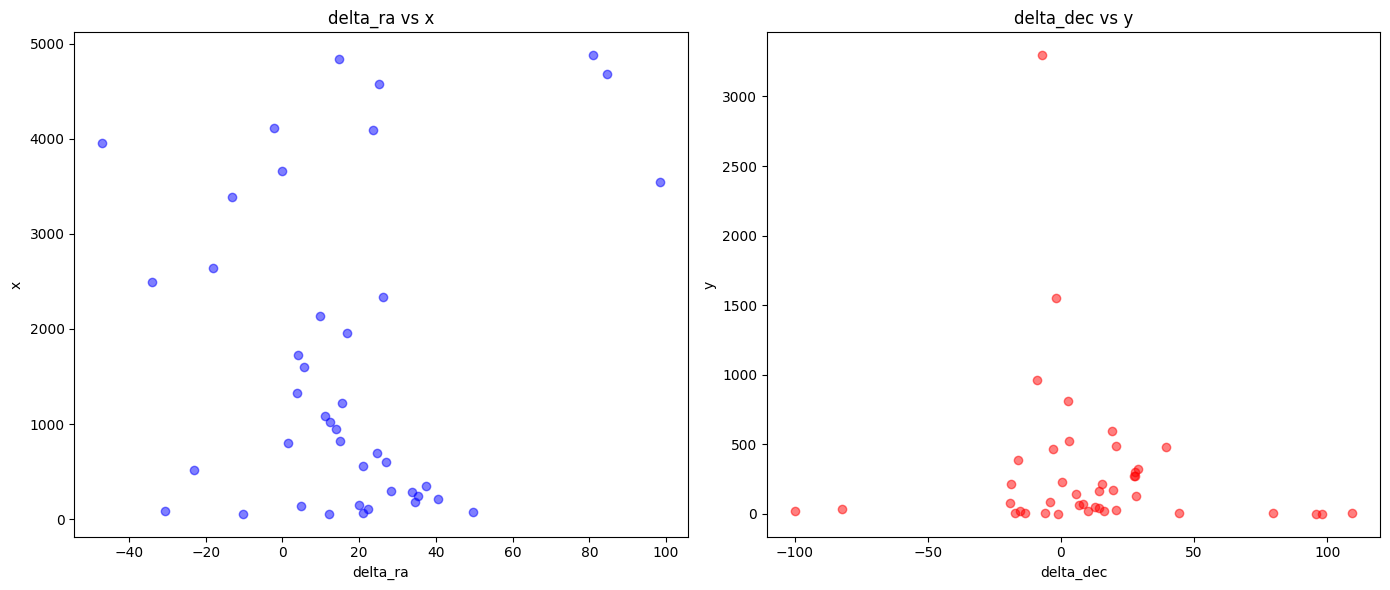

Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: M44_23-24.02.1987_11m_13S-2-6_top42_gaia_143arcsec.fits


In [19]:
# Укажите путь к директории с исходными файлами
data_dir = "/home/izm-ildana/astro/variable_search/data"
output_dir = "/home/izm-ildana/astro/variable_search/output/top"

# Функция для определения изменяющейся координаты на основе заголовка FITS-файла
def determine_x_axis_from_header(fits_file_path):
    with fits.open(fits_file_path) as hdul:
        header = hdul[0].header  # Заголовок первичного HDU с изображением
        
        # Попробуем определить изменяющуюся координату по ключам заголовка
        if 'CTYPE1' in header and 'CTYPE2' in header:
            ctype1 = header['CTYPE1'].lower()
            ctype2 = header['CTYPE2'].lower()
            
            if 'ra' in ctype1:
                return 'ra'
            elif 'dec' in ctype2:
                return 'dec'
        
        # Если не удалось определить, возвращаем 'ra' по умолчанию
        return 'ra'

def visualize_deltas(data):
    # Определяем, какие столбцы использовать для осей
    if data['x_axis'].iloc[0] == 'ra':
        x_values = data['x']
        delta_ra = data['delta_ra']*3600
        delta_dec = data['delta_dec']*3600
        y_values = data['y']
    else:  # Если x_axis == 'dec'
        x_values = data['y']
        delta_ra = data['delta_ra']*3600
        delta_dec = data['delta_dec']*3600
        y_values = data['x']
    
    # Создаем субплоты
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Первый график: delta_ra против x_values или y_values
    ax[0].scatter(delta_ra, x_values, color='blue', alpha=0.5)
    ax[0].set_xlabel('delta_ra')
    ax[0].set_ylabel('x' if data['x_axis'].iloc[0] == 'ra' else 'y')
    ax[0].set_title('delta_ra vs x' if data['x_axis'].iloc[0] == 'ra' else 'delta_ra vs y')

    # Второй график: delta_dec против y_values или x_values
    ax[1].scatter(delta_dec, y_values, color='red', alpha=0.5)
    ax[1].set_xlabel('delta_dec')
    ax[1].set_ylabel('y' if data['x_axis'].iloc[0] == 'ra' else 'x')
    ax[1].set_title('delta_dec vs y' if data['x_axis'].iloc[0] == 'ra' else 'delta_dec vs x')

    # Показываем графики
    plt.tight_layout()
    plt.show()


import os
import pandas as pd
from astropy.io import fits

# Проходим по всем файлам в директории с выходными данными
for filename in os.listdir(output_dir):
    if filename.endswith(".fits"):
        # Разбираем имя файла, чтобы найти исходный файл
        parts = filename.split('_top')[0]  # Извлекаем объект_дата_экспозиция_идентификационныйномер
        original_file = f"{parts}.fit"
        original_path = os.path.join(data_dir, original_file)

        if os.path.exists(original_path):
            # Открываем исходный FITS-файл и определяем изменяющуюся координату на основе заголовка
            x_axis = determine_x_axis_from_header(original_path)

            # Открываем файл, в который нужно добавить новые столбцы
            with fits.open(os.path.join(output_dir, filename), mode='update') as hdul:
                data = pd.DataFrame(hdul[1].data)

                # Добавляем столбец x_axis
                data['x_axis'] = x_axis

                # Вычисляем разницу между координатами
                data['delta_ra'] = data['ra_1'] - data['ra_2']
                data['delta_dec'] = data['dec_1'] - data['dec_2']

                # Визуализация
                visualize_deltas(data)
                # Определяем новый dtype с добавленными столбцами
                new_dtype = np.dtype([
                    ('id', '>i2'), ('x', '>f8'), ('y', '>f8'), ('ra_1', '>f8'), 
                    ('dec_1', '>f8'), ('flux', '>f8'), ('flux_err', '>f8'), 
                    ('mag', '>f8'), ('mag_err', '>f8'), ('flag', '>i2'), 
                    ('a', '>f8'), ('b', '>f8'), ('source_id', '>i8'), 
                    ('ra_2', '>f8'), ('ra_error', '>f4'), ('dec_2', '>f8'), 
                    ('dec_error', '>f4'), ('Separation', '>f8'),
                    ('x_axis', 'S3'),  # Добавляем новый столбец с типом строки длиной 3 символа
                    ('delta_ra', '>f8'),  # Добавляем новый столбец для delta_ra
                    ('delta_dec', '>f8')  # Добавляем новый столбец для delta_dec
                ])

                # Преобразуем DataFrame обратно в numpy array с новым dtype
                new_data_array = np.array([tuple(row) for row in data.to_records(index=False)], dtype=new_dtype)

                # Обновляем таблицу в FITS-файле
                hdul[1].data = new_data_array
                hdul.flush()  # Сохраняем изменения

                print(f"Столбцы 'x_axis', 'delta_ra', 'delta_dec' добавлены в файл: {filename}")
        else:
            print(f"Исходный файл не найден: {original_file}")


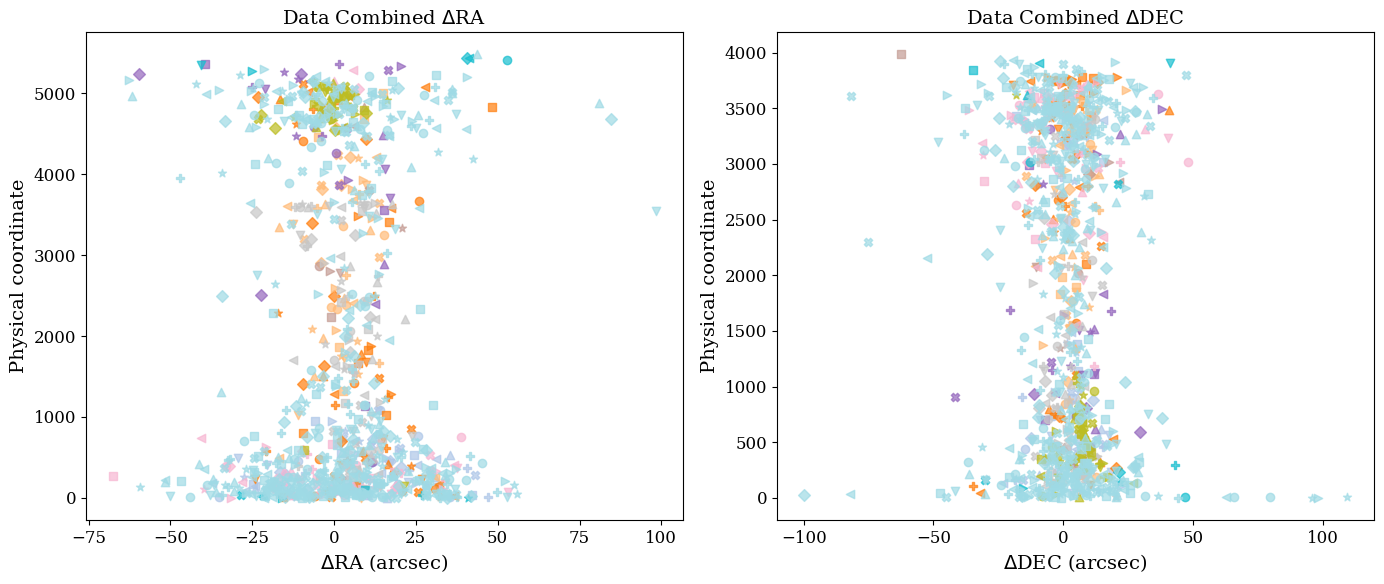

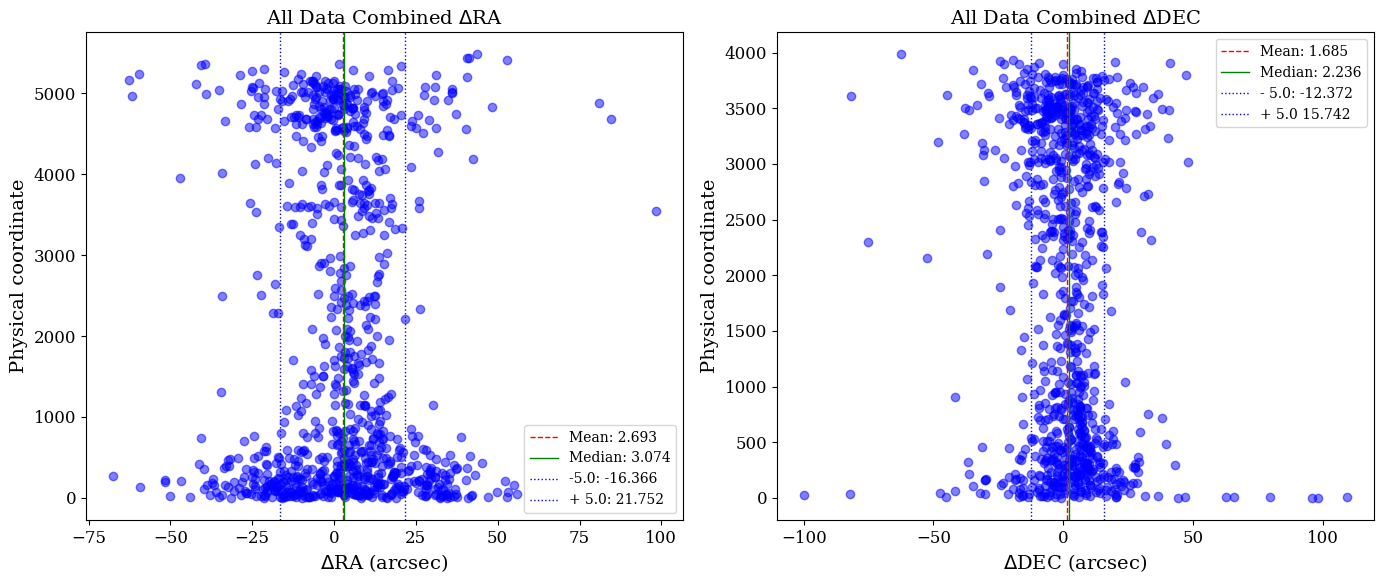

-----RA-----
Maximum =  98.32729055873415
Minimum =  -67.55514864335055
Mean =  2.6928211476729604
Median =  3.0741561738068413
Mean - 5.0*sigma =  -16.366124435744858
Mean + 5.0*sigma =  21.751766731090775
-----DEC-----
Maximum  =  109.36490029387329
Minimum =  -99.89926929540616
Mean =  1.71819316508803
Median =  2.23570440714127
Mean - 5.0*sigma =  -12.371979568590108
Mean + 5.0*sigma =  15.742460336311511


In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

# Путь к директории с FITS-файлами
fits_dir = "/home/izm-ildana/astro/variable_search/output/top"

# Списки для хранения данных из всех файлов
combined_delta_ra = []
combined_delta_dec = []
combined_x = []
combined_y = []
file_indices = []

# Цвета для разных файлов
colors = plt.colormaps.get_cmap('tab20')
markers = cycle(['o', 's', 'D', '^', 'v', '<', '>', 'P', '*', 'X'])

# Проходим по всем файлам в директории и объединяем данные
for i, filename in enumerate(os.listdir(fits_dir)):
    if filename.endswith(".fits"):
        file_path = os.path.join(fits_dir, filename)
        
        with fits.open(file_path) as hdul:
            data = pd.DataFrame(hdul[1].data)
            data['delta_ra_arcsec'] = data['delta_ra']*3600
            data['delta_dec_arcsec']= data['delta_dec']*3600
            # Собираем данные
            combined_delta_ra.extend(data['delta_ra_arcsec'])
            combined_delta_dec.extend(data['delta_dec_arcsec'])
            if data['x_axis'].iloc[0] == 'ra':
                combined_x.extend(data['x'])
                combined_y.extend(data['y'])
            else:
                combined_x.extend(data['y'])
                combined_y.extend(data['x'])
            
            # Добавляем индекс файла для цветового кодирования
            file_indices.extend([i] * len(data))

# Визуализация объединенных данных с разными цветами и маркерами для каждого файла
plt.figure(figsize=(14, 6))

# Первый график: delta_ra против x
plt.subplot(1, 2, 1)
for i in range(len(combined_delta_ra)):
    plt.scatter(combined_delta_ra[i], combined_x[i], 
                color=colors(file_indices[i]), 
                marker=next(markers), 
                alpha=0.7, 
                label=f'File {file_indices[i] + 1}' if i == 0 else "")

plt.xlabel(r'$\Delta$RA (arcsec)')
plt.ylabel('Physical coordinate')
plt.title(r'Data Combined $\Delta$RA')

# Второй график: delta_dec против y
plt.subplot(1, 2, 2)
for i in range(len(combined_delta_dec)):
    plt.scatter(combined_delta_dec[i], combined_y[i], 
                color=colors(file_indices[i]), 
                marker=next(markers), 
                alpha=0.7, 
                label=f'File {file_indices[i] + 1}' if i == 0 else "")

plt.xlabel(r'$\Delta$DEC (arcsec)')
plt.ylabel('Physical coordinate')
plt.title(r'Data Combined $\Delta$DEC')

plt.tight_layout()
plt.show()

sigma = 5.0

# Создаем фигуру и оси для субплотов
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# delta_ra против x
ax[0].scatter(combined_delta_ra, combined_x, color='blue', alpha=0.5)
ax[0].set_xlabel(r'$\Delta$RA (arcsec)')
ax[0].set_ylabel('Physical coordinate')
ax[0].set_title(r'All Data Combined $\Delta$RA')

# Вычисляем статистику с использованием sigma_clipped_stats для delta_ra
mean_ra, median_ra, std_ra = sigma_clipped_stats(combined_delta_ra, sigma=sigma)

# Добавляем вертикальные линии на первый график для среднего, медианы и стандартного отклонения
ax[0].axvline(mean_ra, color='r', linestyle='--', label=f'Mean: {mean_ra:.3f}')
ax[0].axvline(median_ra, color='g', linestyle='-', label=f'Median: {median_ra:.3f}')
ax[0].axvline(mean_ra - std_ra, color='b', linestyle=':', label=f'-{sigma}: {mean_ra - std_ra:.3f}')
ax[0].axvline(mean_ra + std_ra, color='b', linestyle=':', label=f'+ {sigma}: {mean_ra + std_ra:.3f}')
ax[0].legend()

# delta_dec против y
ax[1].scatter(combined_delta_dec, combined_y, color='blue', alpha=0.5)
ax[1].set_xlabel(r'$\Delta$DEC (arcsec)')
ax[1].set_ylabel('Physical coordinate')
ax[1].set_title(r'All Data Combined $\Delta$DEC')

# Вычисляем статистику с использованием sigma_clipped_stats для delta_dec
mean_dec, median_dec, std_dec = sigma_clipped_stats(combined_delta_dec, sigma=sigma)

# Добавляем вертикальные линии на второй график для среднего, медианы и стандартного отклонения
ax[1].axvline(mean_dec, color='r', linestyle='--', label=f'Mean: {mean_dec:.3f}')
ax[1].axvline(median_dec, color='g', linestyle='-', label=f'Median: {median_dec:.3f}')
ax[1].axvline(mean_dec - std_dec, color='b', linestyle=':', label=f'- {sigma}: {mean_dec - std_dec:.3f}')
ax[1].axvline(mean_dec + std_dec, color='b', linestyle=':', label=f'+ {sigma} {mean_dec + std_dec:.3f}')
ax[1].legend()

# Оптимизация расположения графиков
plt.tight_layout()
plt.show()

print(r"-----RA-----")
print(rf"Maximum = ", np.max(combined_delta_ra))
print(rf"Minimum = ", np.min(combined_delta_ra))
print(rf"Mean = ", np.mean(combined_delta_ra))
print(rf"Median = ", np.median(combined_delta_ra))
print(rf"Mean - {sigma}*sigma = ", mean_ra - std_ra)
print(rf"Mean + {sigma}*sigma = ", mean_ra + std_ra)


print(r"-----DEC-----")

print(rf"Maximum  = ", np.max(combined_delta_dec))
print(rf"Minimum = ", np.min(combined_delta_dec))
print(rf"Mean = ", np.mean(combined_delta_dec))
print(rf"Median = ", np.median(combined_delta_dec))
print(rf"Mean - {sigma}*sigma = ", mean_dec - std_dec)
print(rf"Mean + {sigma}*sigma = ", mean_dec + std_dec)